In [14]:
import numpy as np
import pandas as pd
%matplotlib notebook
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.feature_selection import *
import seaborn as sns
from scipy import stats
import warnings
from numpy import median
from matplotlib.pyplot import cm
warnings.filterwarnings('ignore')

In [15]:
def regPlots(df,x,y,col,row,ylim=None,color='#ff7f03',fsize=[5,20],xlim=None,yerrd=np.array([None,None])):
    plt.figure(figsize=fsize)
    c = 1
    row_ls = list(set(df[row]))
    col_ls = sorted(list(set(df[col])))
    nRow = len(row_ls)
    nCol = len(col_ls)
    for i in range(nRow):
        for j in range(nCol):
            ax = plt.subplot(nRow,nCol,c)
            d = df.loc[(df[col]==col_ls[j])&(df[row]==row_ls[i])]
            #sns.regplot(x=x,y=y,data=d,ci=None,color=color,scatter_kws={'facecolors':d['color'],'edgecolors':d['color']},fit_reg=False) #blue '#1f77b4'
            #for cc in set(d.color):
            #    plt.plot(d.loc[d.color==cc][x],d.loc[d.color==cc][y],marker='.',linestyle='-',color=cc)
            axs = sns.lineplot(data=d, x=x, y=y, hue="topology", markers=["o","*",">","<","."], ci=None, style='topology', dashes=False)
            axs.get_legend().remove()
            
            if all(yerrd != None):
                yerr = []
                x_e = []
                y_e = []
                for tpl in d["topology"]:
                    for k in set(d[x]):
                        yerr.append(yerrd.loc[(yerrd[col]==col_ls[j])&(yerrd[row]==row_ls[i])&(yerrd[x]==k)&(yerrd.topology==tpl)][y].std())
                        x_e.append(d.loc[(d[x]==k)&(d.topology==tpl)][x].mean())
                        y_e.append(d.loc[(d[x]==k)&(d.topology==tpl)][y].mean())
                    ax.errorbar(x_e, y_e, yerr=yerr, fmt='none', capsize=5, zorder=1, color='grey')
                    
            #plt.legend(bbox_to_anchor=(1.1,0.5,1,0.5), loc=2, borderaxespad=0.)
            if ylim != None:
                plt.ylim(ylim)
            else:
                plt.ylim(bottom=0)
            if xlim != None:
                plt.xlim(xlim)
            c += 1
            plt.title(col_ls[j])
    plt.legend(bbox_to_anchor=(1.1,0.5,1,0.5), loc=2, borderaxespad=0.) 
    plt.xlabel(x)
    plt.ylabel(y)
    plt.subplots_adjust(wspace=0.3,hspace=0.3)
    plt.show()

In [16]:
tpl25 = pd.read_table("WL7-4_result_d05/topology_N25_dg",delimiter=' ')
tpl50 = pd.read_table("WL7-4_result_d05/topology_N50_dg",delimiter=' ')
tpl100 = pd.read_table("WL7-4_result_d05/topology_N100_dg",delimiter=' ')
tpl500 = pd.read_table("WL7-4_result_d05/topology_N500_dg",delimiter=' ')
tpl750 = pd.read_table("WL7-4_result_d05/topology_N750_dg",delimiter=' ')

### Parameters fixed in this notebook are: delta=0.001, r=07, h=0.1

### Full model with asymmetric interaction matrix (C)

In [17]:
#df25 = pd.read_table("WL7-4_results_wIm_2021-Mar-18/randc_2021-May-9/Results_WL7-4_5nets_N25e25_h0.1_asym_seed0.txt",delimiter=' ')
df25 = pd.read_table("WL7-4_results_2022-Feb-4/Results_WL7-4_5nets_N25e25_h0.1_asym_seed0.txt",delimiter=' ')
df25 = pd.merge(df25,tpl25,on='NetName')
#df50 = pd.read_table("WL7-4_results_wIm_2021-Mar-18/randc_2021-May-9/Results_WL7-4_5nets_N50e50_h0.1_asym_seed0.txt",delimiter=' ')
df50 = pd.read_table("WL7-4_results_2022-Feb-4/Results_WL7-4_5nets_N50e50_h0.1_asym_seed0.txt",delimiter=' ')
df50 = pd.merge(df50,tpl50,on='NetName')
#df100 = pd.read_table("WL7-4_results_wIm_2021-Mar-18/randc_2021-May-9/Results_WL7-4_5nets_N100e100_h0.1_asym_seed0.txt",delimiter=' ')
df100 = pd.read_table("WL7-4_results_2022-Feb-4/Results_WL7-4_5nets_N100e100_h0.1_asym_seed0.txt",delimiter=' ')
df100 = pd.merge(df100,tpl100,on='NetName')
#df500 = pd.read_table("WL7-4_results_wIm_2021-Mar-18/randc_2021-May-9/Results_WL7-4_5nets_N500e500_h0.1_asym_seed0.txt",delimiter=' ')
df500 = pd.read_table("WL7-4_results_2022-Feb-4/Results_WL7-4_5nets_N500e500_h0.1_asym_seed0.txt",delimiter=' ')
df500 = pd.merge(df500,tpl500,on='NetName')
#df750 = pd.read_table("WL7-4_results_wIm_2021-Mar-18/randc_2021-May-9/Results_WL7-4_5nets_N750e750_h0.1_asym_seed0.txt",delimiter=' ')
df750 = pd.read_table("WL7-4_results_2022-Feb-4/Results_WL7-4_5nets_N750e750_h0.1_asym_seed0.txt",delimiter=' ')
df750 = pd.merge(df750,tpl750,on='NetName')
df1 = pd.concat([df25,df50,df100,df500,df750],axis=0)
total = len(df1)
df = df1.replace([np.inf, -np.inf],np.nan).dropna()
topology = []
nNode = []
for i in df.NetName:
    name = i.split('_')[1]
    node = i.split('_')[0].split('e')[0].strip('N')
    topology.append(name)
    nNode.append(int(node))
df['topology'] = topology
df['nNode'] = nNode
pd.options.display.max_columns = df.shape[1]
dfall = df.loc[df.tot_biomass!='extinction']

cols=[]
cpalette = sns.color_palette("Set2", 5)

for i in dfall.topology:
    if i == "Complete":
        cols.append(cpalette[0])
    elif i == "Grid":
        cols.append(cpalette[1])
    elif i == "Linear":
        cols.append(cpalette[2])
    elif i == "SmallWorld":
        cols.append(cpalette[3])
    elif i == "Tree":
        cols.append(cpalette[4])
dfall['color'] = cols

dfall["inv_CVcr"] = 1 / dfall["CVcr"]

<IPython.core.display.Javascript object>


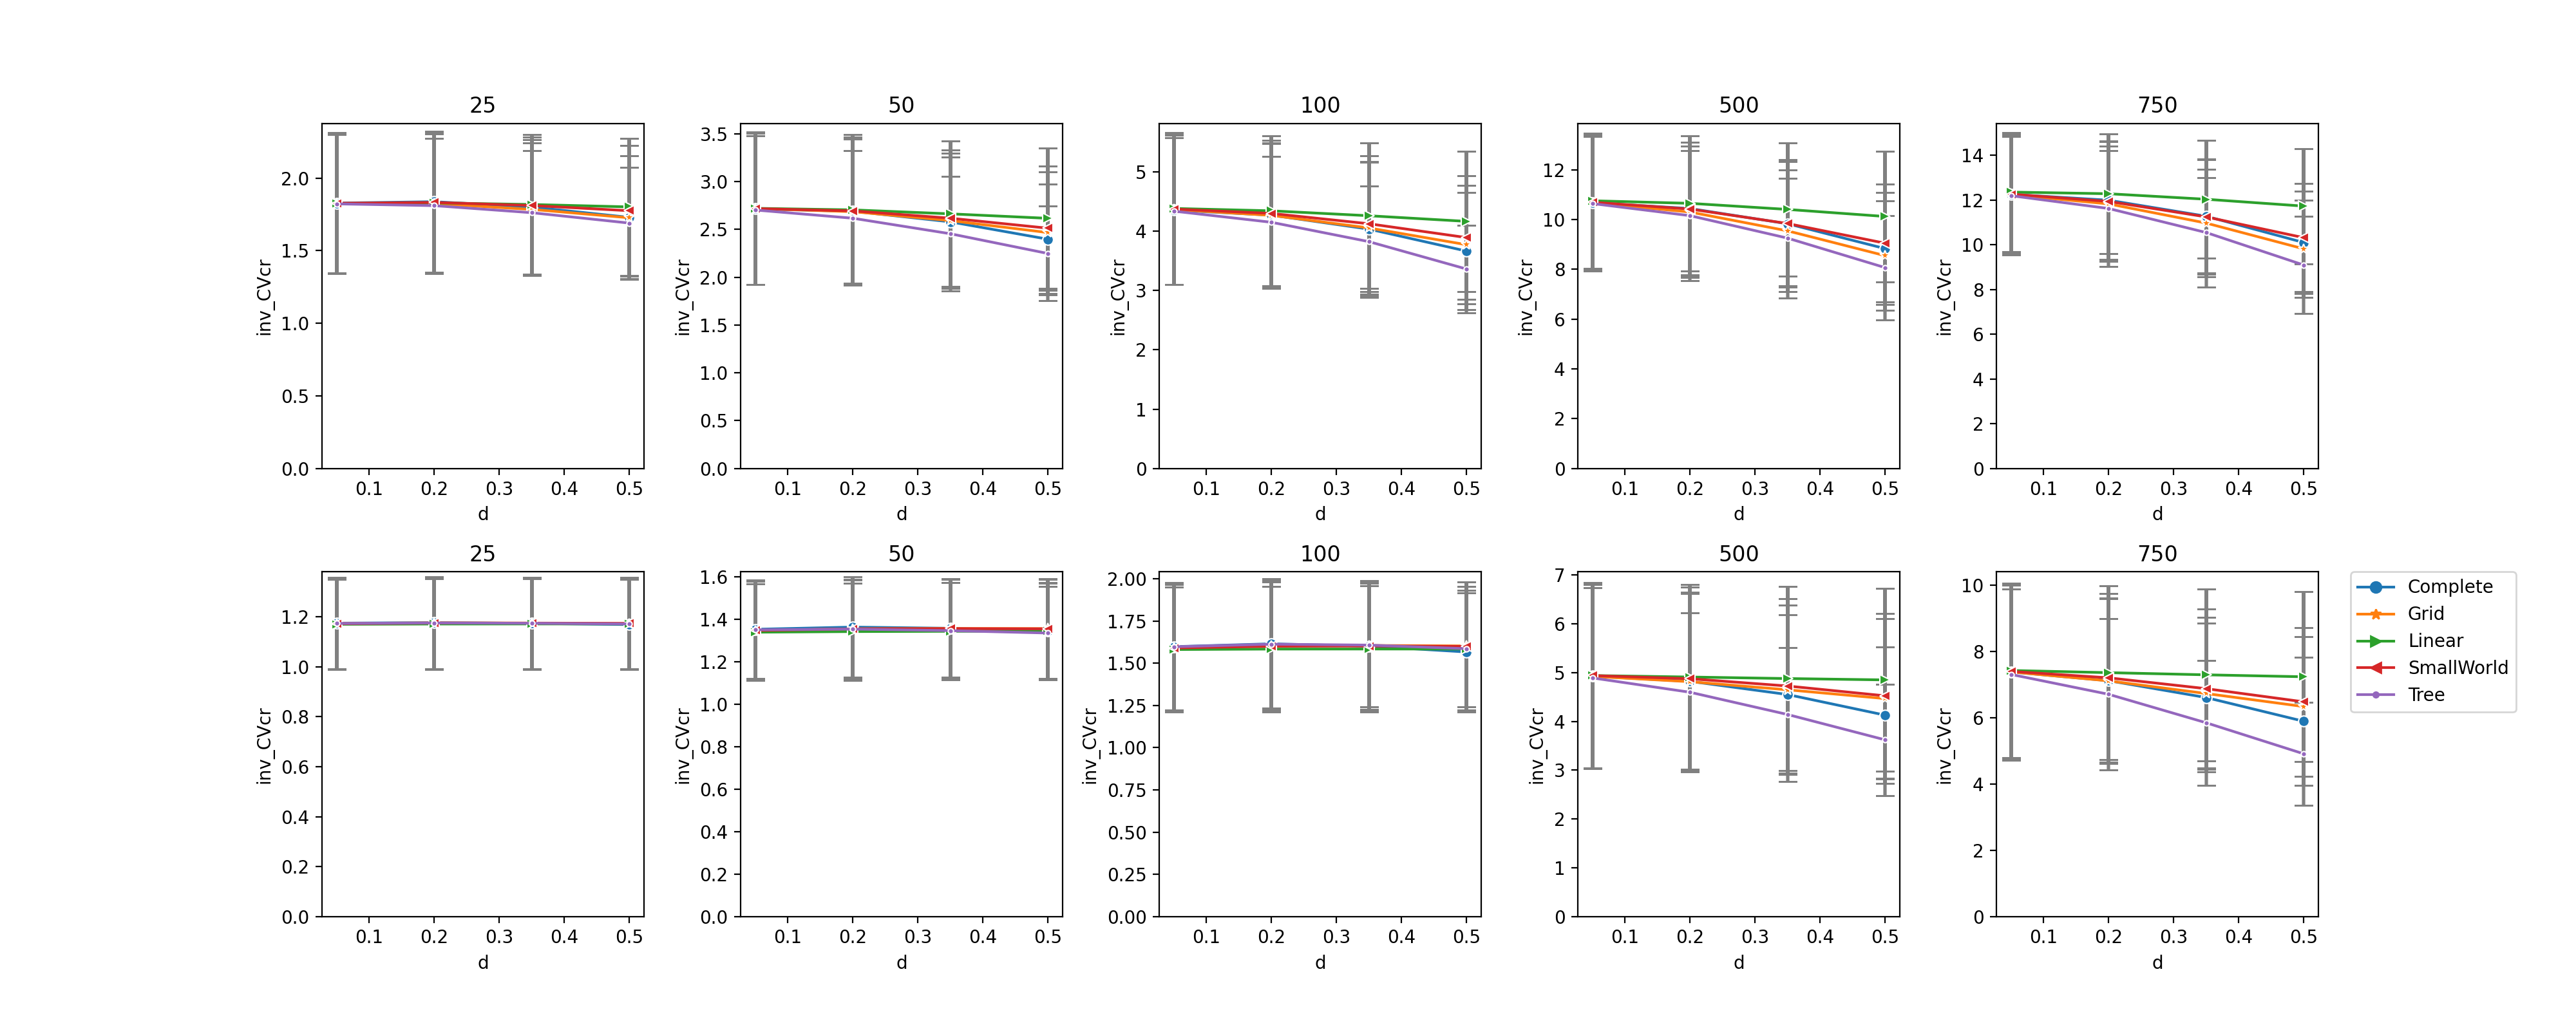

In [17]:
df = dfall.loc[(dfall.r_std==1)&(dfall.rho_eta_hetero==0.8)].groupby(['NetName','d','rho_eta_fluc','color','topology'],as_index=False).agg(np.mean)
yerrd=dfall.loc[(dfall.r_std==1)&(dfall.rho_eta_hetero==0.8)]
regPlots(df,"d","inv_CVcr","nNode","rho_eta_fluc",color='grey',yerrd=yerrd,xlim=None,ylim=None,fsize=[20,8])

### Fig.2 (a), (b)

<IPython.core.display.Javascript object>


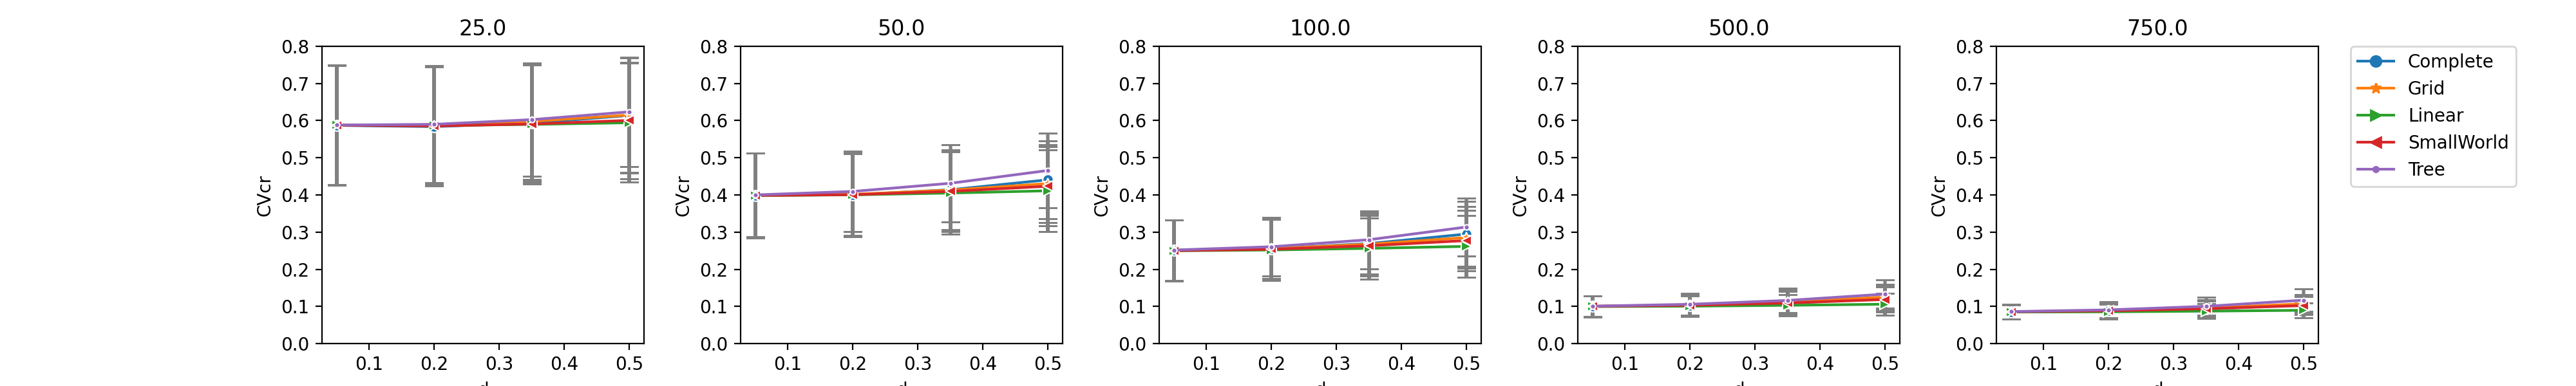

In [10]:
df = dfall.loc[(dfall.r_std==1)&(dfall.rho_eta_hetero==0.8)&(dfall.rho_eta_fluc==0.95)].groupby(['NetName','d','rho_eta_fluc','color','topology'],as_index=False).agg(np.mean)
yerrd=dfall.loc[(dfall.r_std==1)&(dfall.rho_eta_hetero==0.8)&(dfall.rho_eta_fluc==0.95)]
regPlots(df,"d","CVcr","nNode","rho_eta_fluc",color='grey',yerrd=yerrd,xlim=None,ylim=[0,0.8],fsize=[20,3])
# Figure 2a (N=25)

<IPython.core.display.Javascript object>


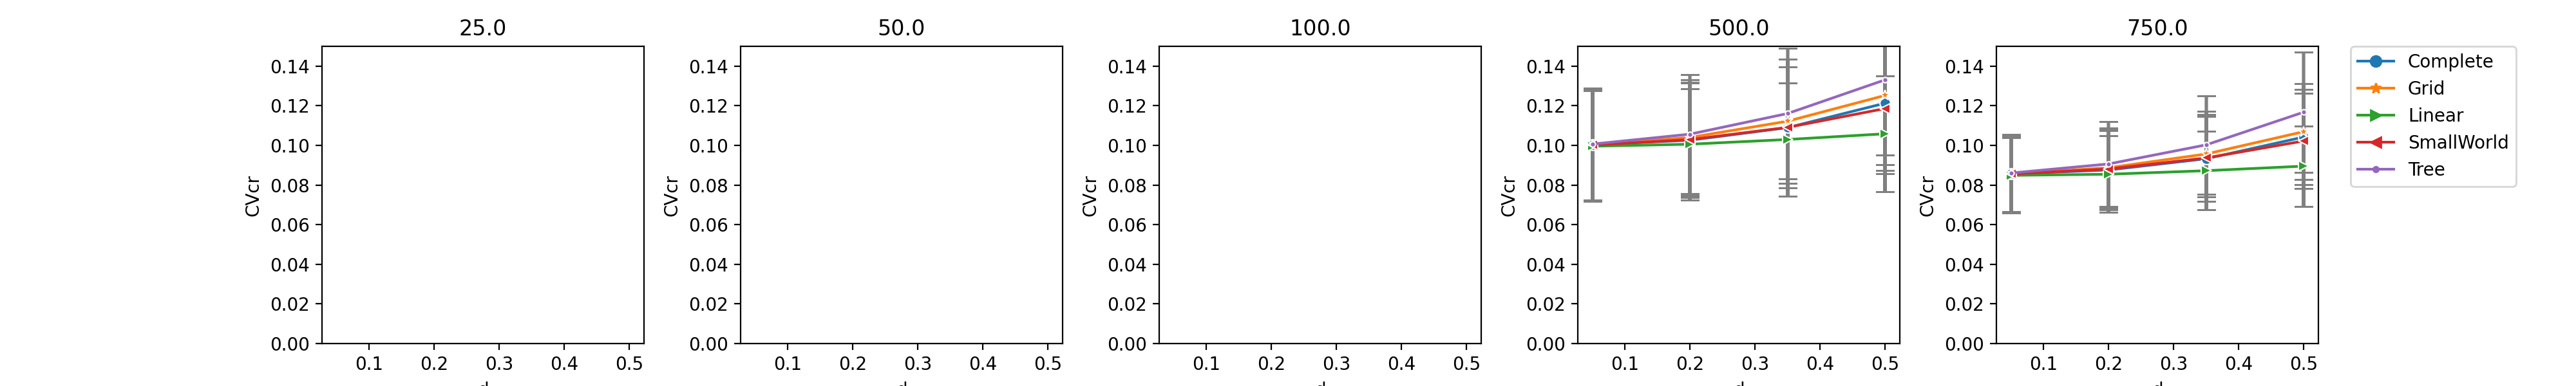

In [11]:
df = dfall.loc[(dfall.r_std==1)&(dfall.rho_eta_hetero==0.8)&(dfall.rho_eta_fluc==0.95)].groupby(['NetName','d','rho_eta_fluc','color','topology'],as_index=False).agg(np.mean)
yerrd=dfall.loc[(dfall.r_std==1)&(dfall.rho_eta_hetero==0.8)&(dfall.rho_eta_fluc==0.95)]
regPlots(df,"d","CVcr","nNode","rho_eta_fluc",color='grey',yerrd=yerrd,xlim=None,ylim=[0,0.15],fsize=[20,3])
# Figure 2b (N=750): same as above, except ylim=[0,0.15]

In [8]:
# https://people.richland.edu/james/lecture/m170/ch13-1wy.html
data = dfall.loc[(dfall.r_std==1.0)&(dfall.d==0.5)&(dfall.rho_eta_hetero==0.8)&(dfall.rho_eta_fluc==0.95)]
GM = data.mean()[dfall.columns[1:9]]
# total variation
SST = 0
for i in data[data.columns[1:9]].values:
    SST += (i - GM)**2
#SST = data.var(axis=0,ddof=0)[dfall.columns[1:9]]
print('total variation\n', SST)

# between-group variation
SSB = 0
for name in set(data.NetName):
    d = data.loc[data.NetName==name]
    n = len(d)
    SSB += n * (d.mean()[data.columns[1:9]] - GM)**2
print('between-group variation\n',SSB)

# within-group variation
SSW = SST - SSB
print('within-group variation\n',SSW)

#SSW2 = 0
#for name in set(data.NetName):
#    d = data.loc[data.NetName==name]
#    n = len(d)
#    for i in d.values:
#        SSW2 += (i[1:9] - d.mean()[data.columns[1:9]])**2
#print('within-group variation2\n', SSW2)
# this is confirmed to be same as SST - SSB above!


N = len(data)
k = len(set(data.NetName))
MSB = SSB / (k-1)
MSW = SSW / (N-k)
print('F-value\n',MSB/MSW)

total variation
 CVcr     114.046818
CVcl      33.946748
CVsr     473.064378
CVsl     148.839364
phi_r     23.880753
phi_l      9.765225
phi_c    159.470519
phi_s    143.303496
dtype: float64
between-group variation
 CVcr      92.461572
CVcl      11.951465
CVsr     436.784089
CVsl     113.795747
phi_r      0.723332
phi_l      1.958276
phi_c    149.511412
phi_s    137.764774
dtype: float64
within-group variation
 CVcr     21.585247
CVcl     21.995283
CVsr     36.280289
CVsl     35.043616
phi_r    23.157421
phi_l     7.806949
phi_c     9.959108
phi_s     5.538723
dtype: float64
F-value
 CVcr      441.741519
CVcl       56.034505
CVsr     1241.538042
CVsl      334.873727
phi_r       3.221154
phi_l      25.867626
phi_c    1548.167245
phi_s    2565.030454
dtype: float64


### Figure 2(c)

<IPython.core.display.Javascript object>


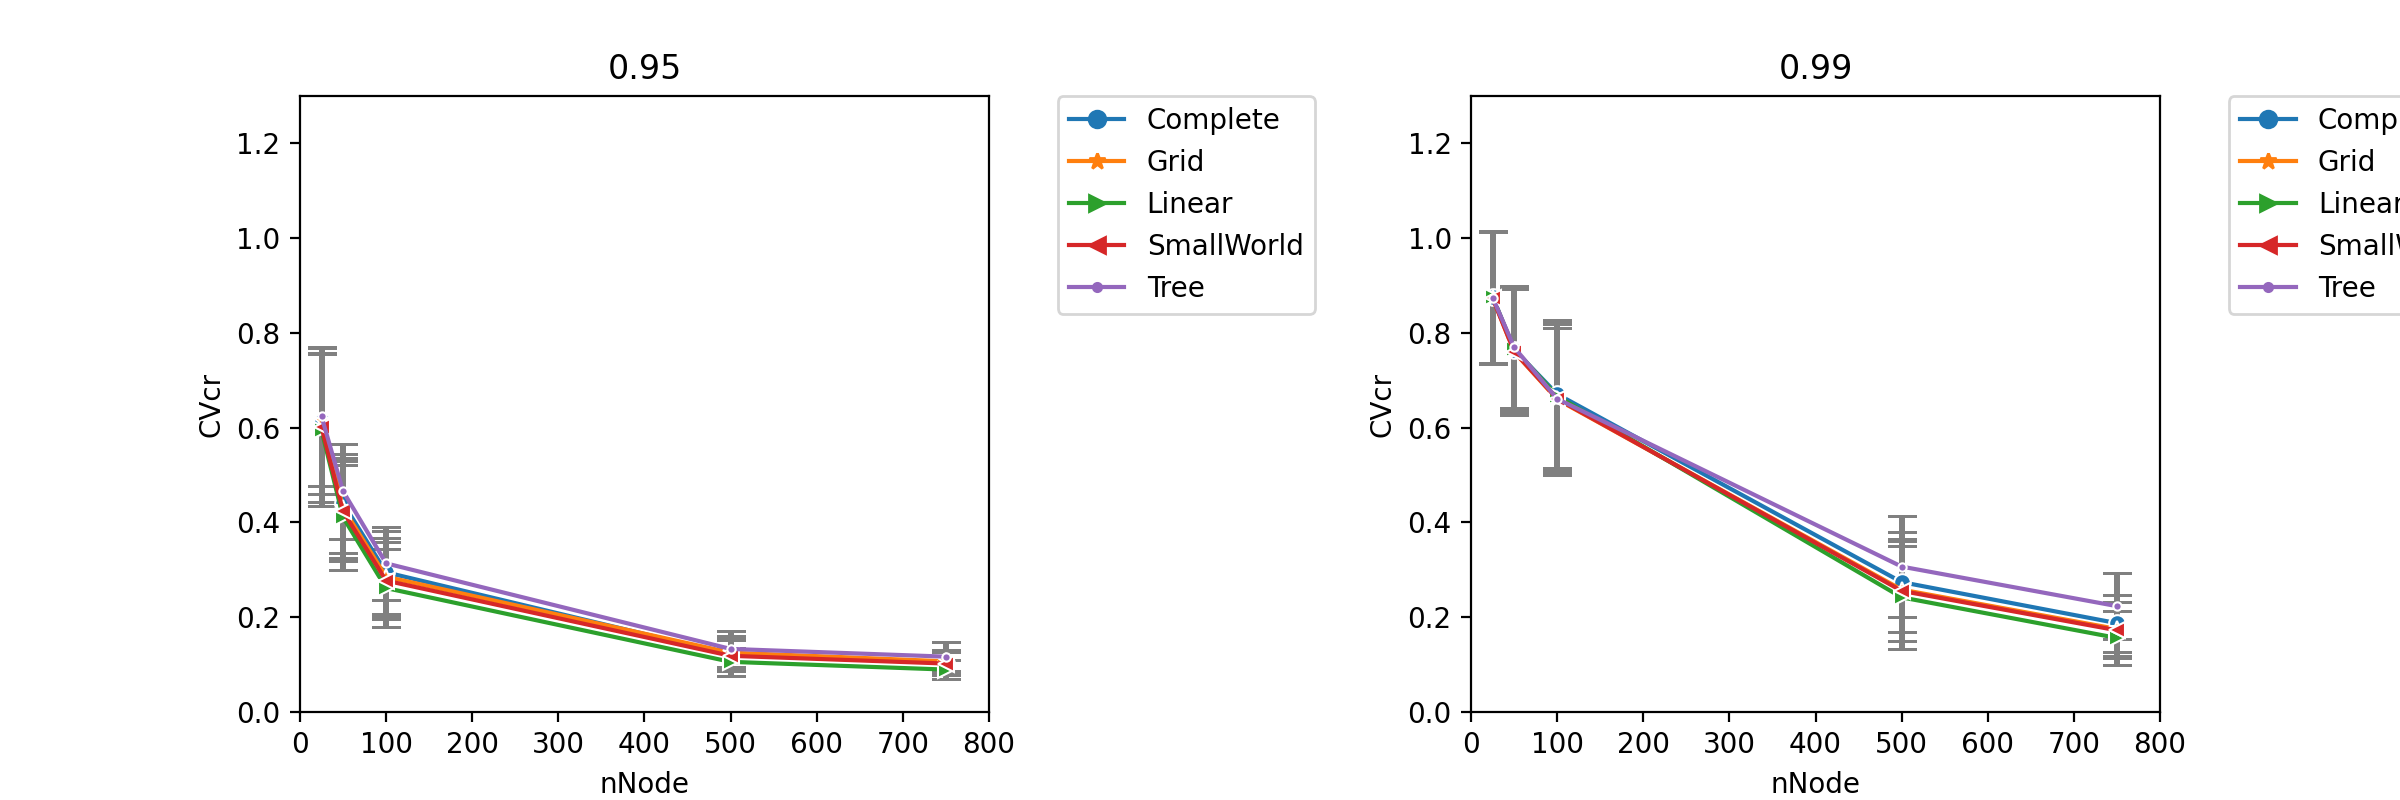

In [31]:
df = dfall.loc[(dfall.r_std==1.0)&(dfall.rho_eta_hetero==0.8)&(dfall.d==0.5)].groupby(['NetName','d','rho_eta_fluc','color','topology'],as_index=False).agg(np.mean)
yerrd=dfall.loc[(dfall.r_std==1.0)&(dfall.rho_eta_hetero==0.8)&(dfall.d==0.5)]
regPlots(df,"nNode","CVcr","rho_eta_fluc","Neutral",color='grey',yerrd=yerrd,xlim=[0,800],ylim=[0,1.3],fsize=[12,4])
# left: Figure 2(c)

### Fig.2(d)

<IPython.core.display.Javascript object>


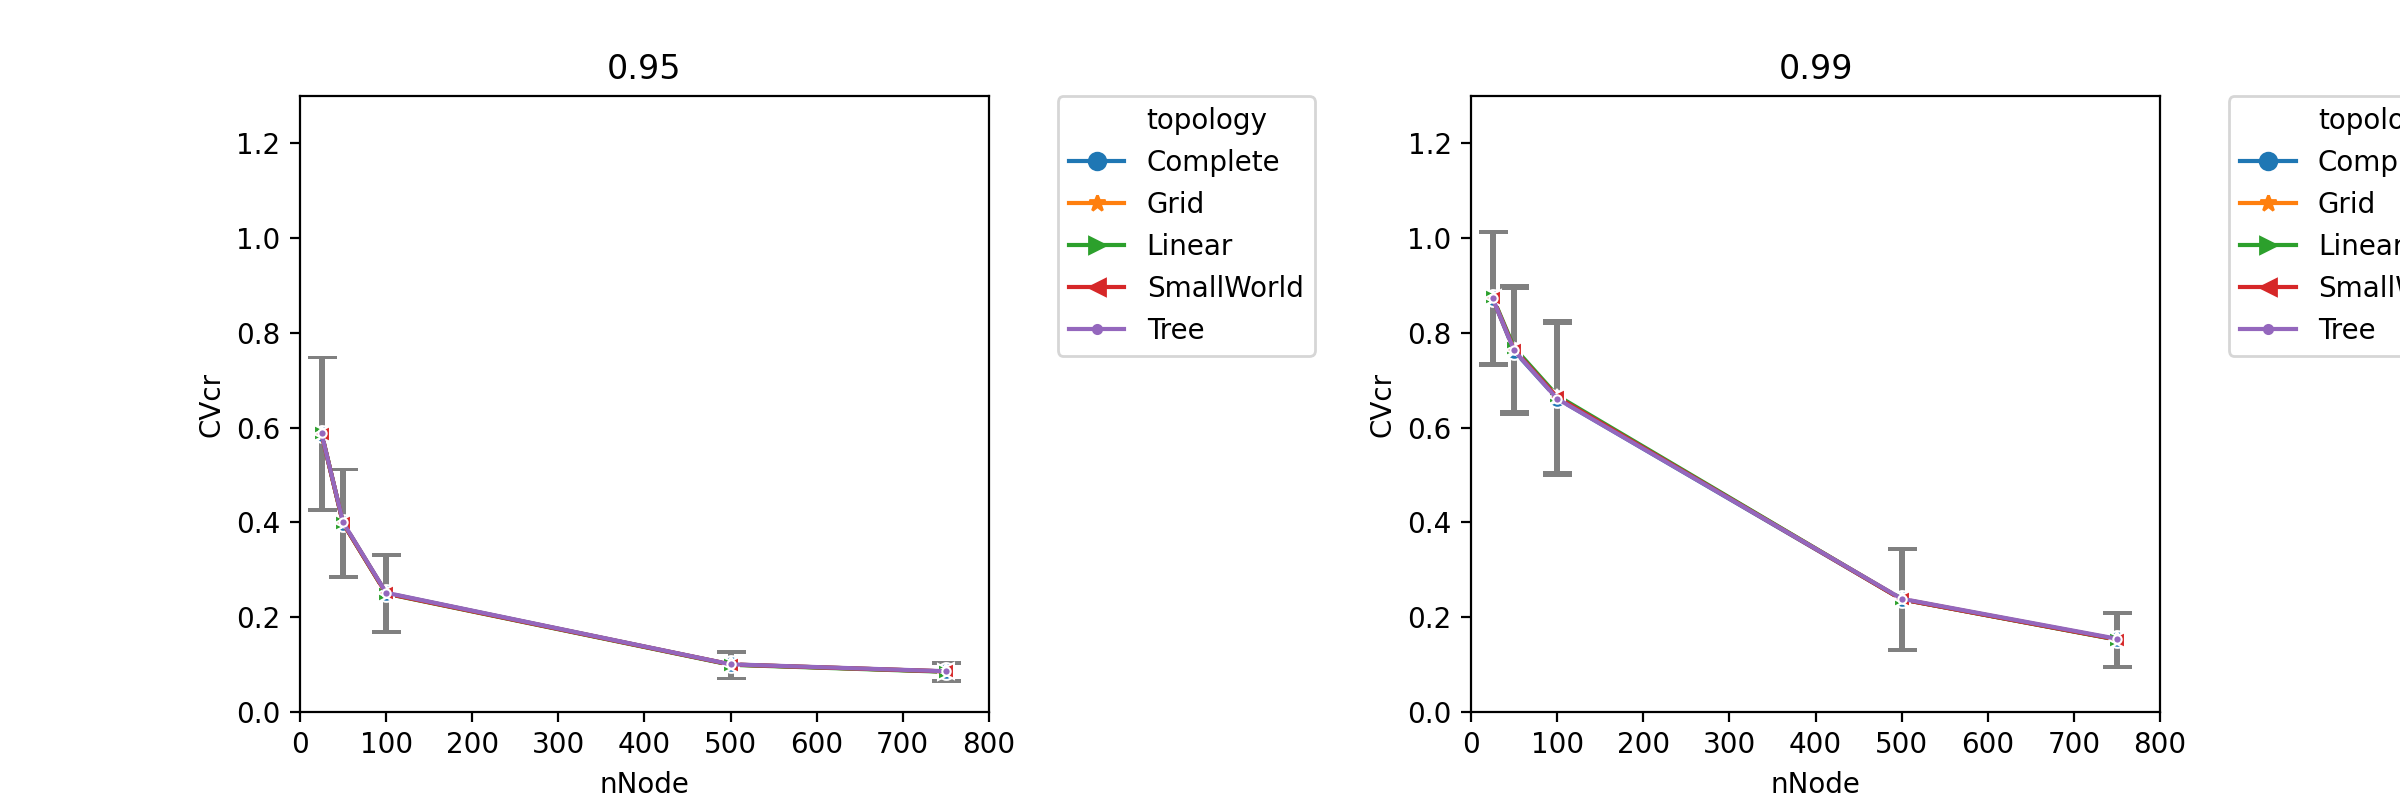

In [8]:
df = dfall.loc[(dfall.r_std==1.0)&(dfall.rho_eta_hetero==0.8)&(dfall.d==0.05)].groupby(['NetName','d','rho_eta_fluc','color','topology'],as_index=False).agg(np.mean)
yerrd=dfall.loc[(dfall.r_std==1.0)&(dfall.rho_eta_hetero==0.8)&(dfall.d==0.05)]
regPlots(df,"nNode","CVcr","rho_eta_fluc","Neutral",color='grey',yerrd=yerrd,xlim=[0,800],ylim=[0,1.3])
# left: Figure 2d

### Figure 3 (a, b,c,d), Figure A1(a,b,c,f)

<IPython.core.display.Javascript object>


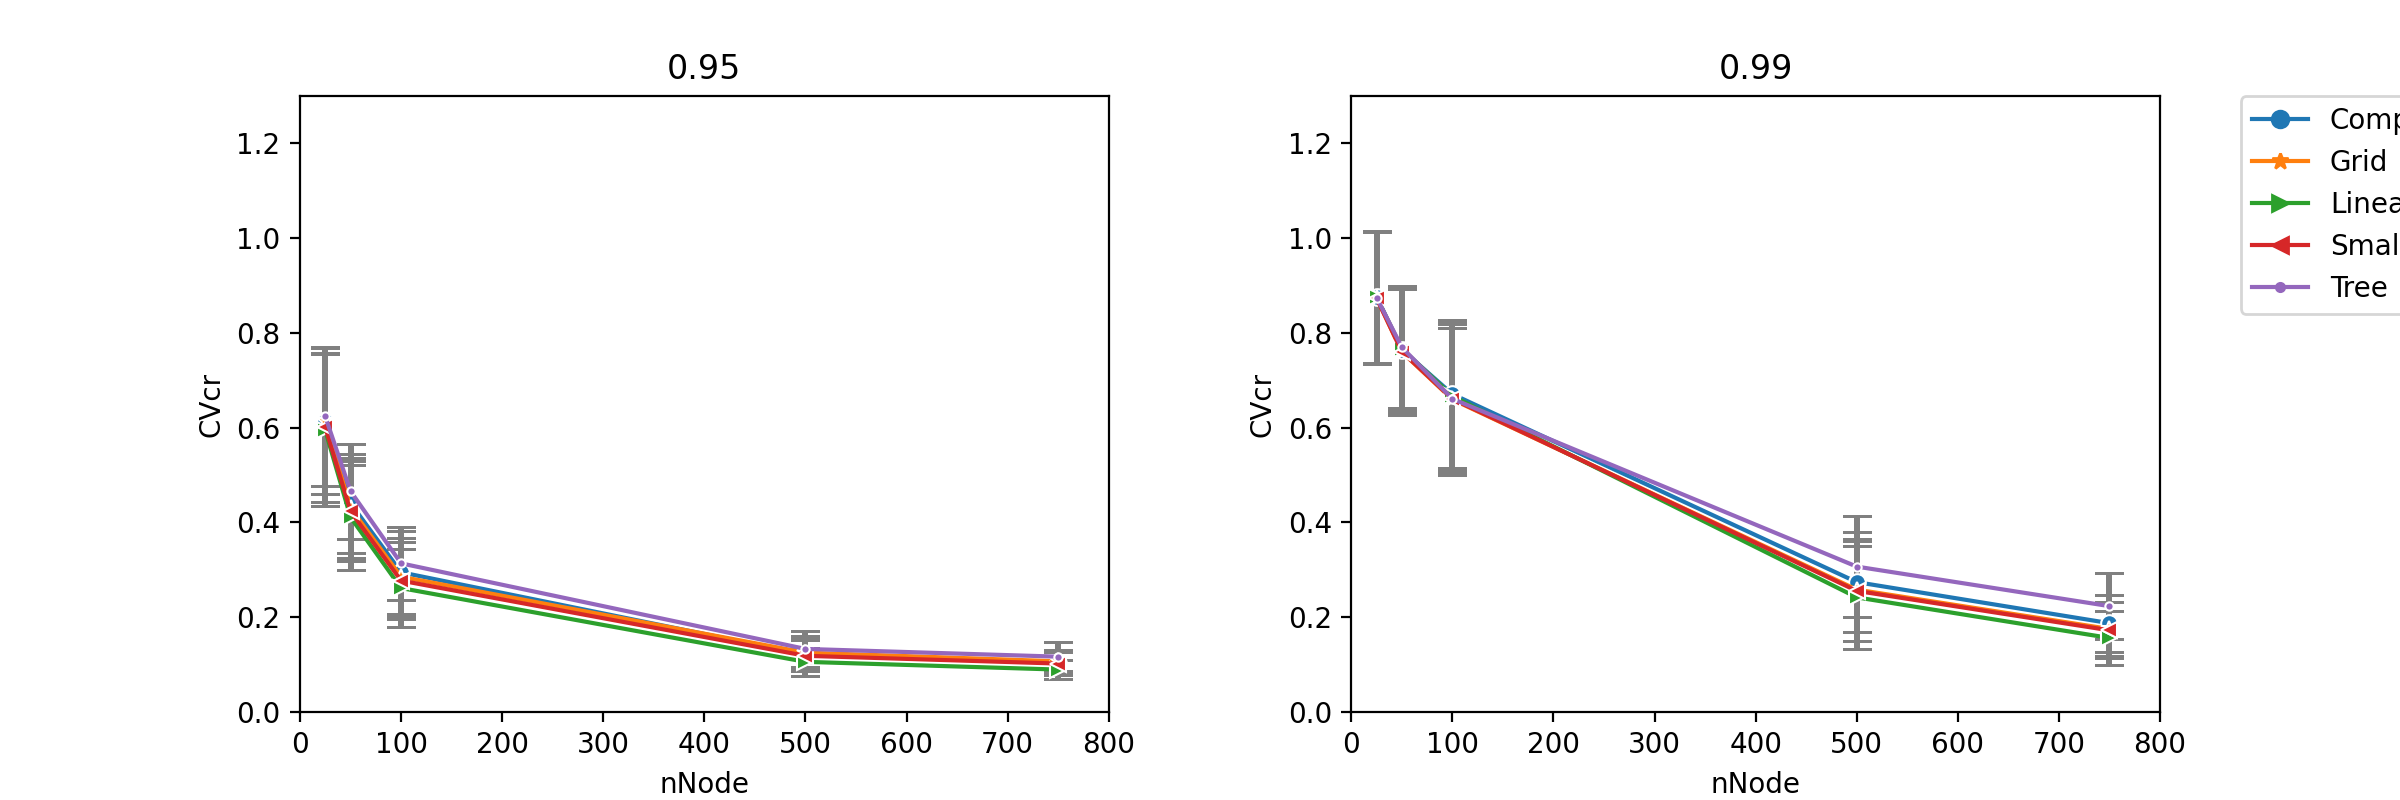

In [18]:
df = dfall.loc[(dfall.r_std==1)&(dfall.rho_eta_hetero==0.8)&(dfall.d==0.5)].groupby(['NetName','d','rho_eta_fluc','color','topology'],as_index=False).agg(np.mean)
yerrd=dfall.loc[(dfall.r_std==1)&(dfall.rho_eta_hetero==0.8)&(dfall.d==0.5)]
regPlots(df,"nNode","CVcr","rho_eta_fluc","Neutral",color='grey',yerrd=yerrd,xlim=[0,800],ylim=[0,1.3],fsize=[12,4])
# left: Figure 3(a) and Figure A1(a), right: Figure 3(c) and Figure A1(f)

<IPython.core.display.Javascript object>


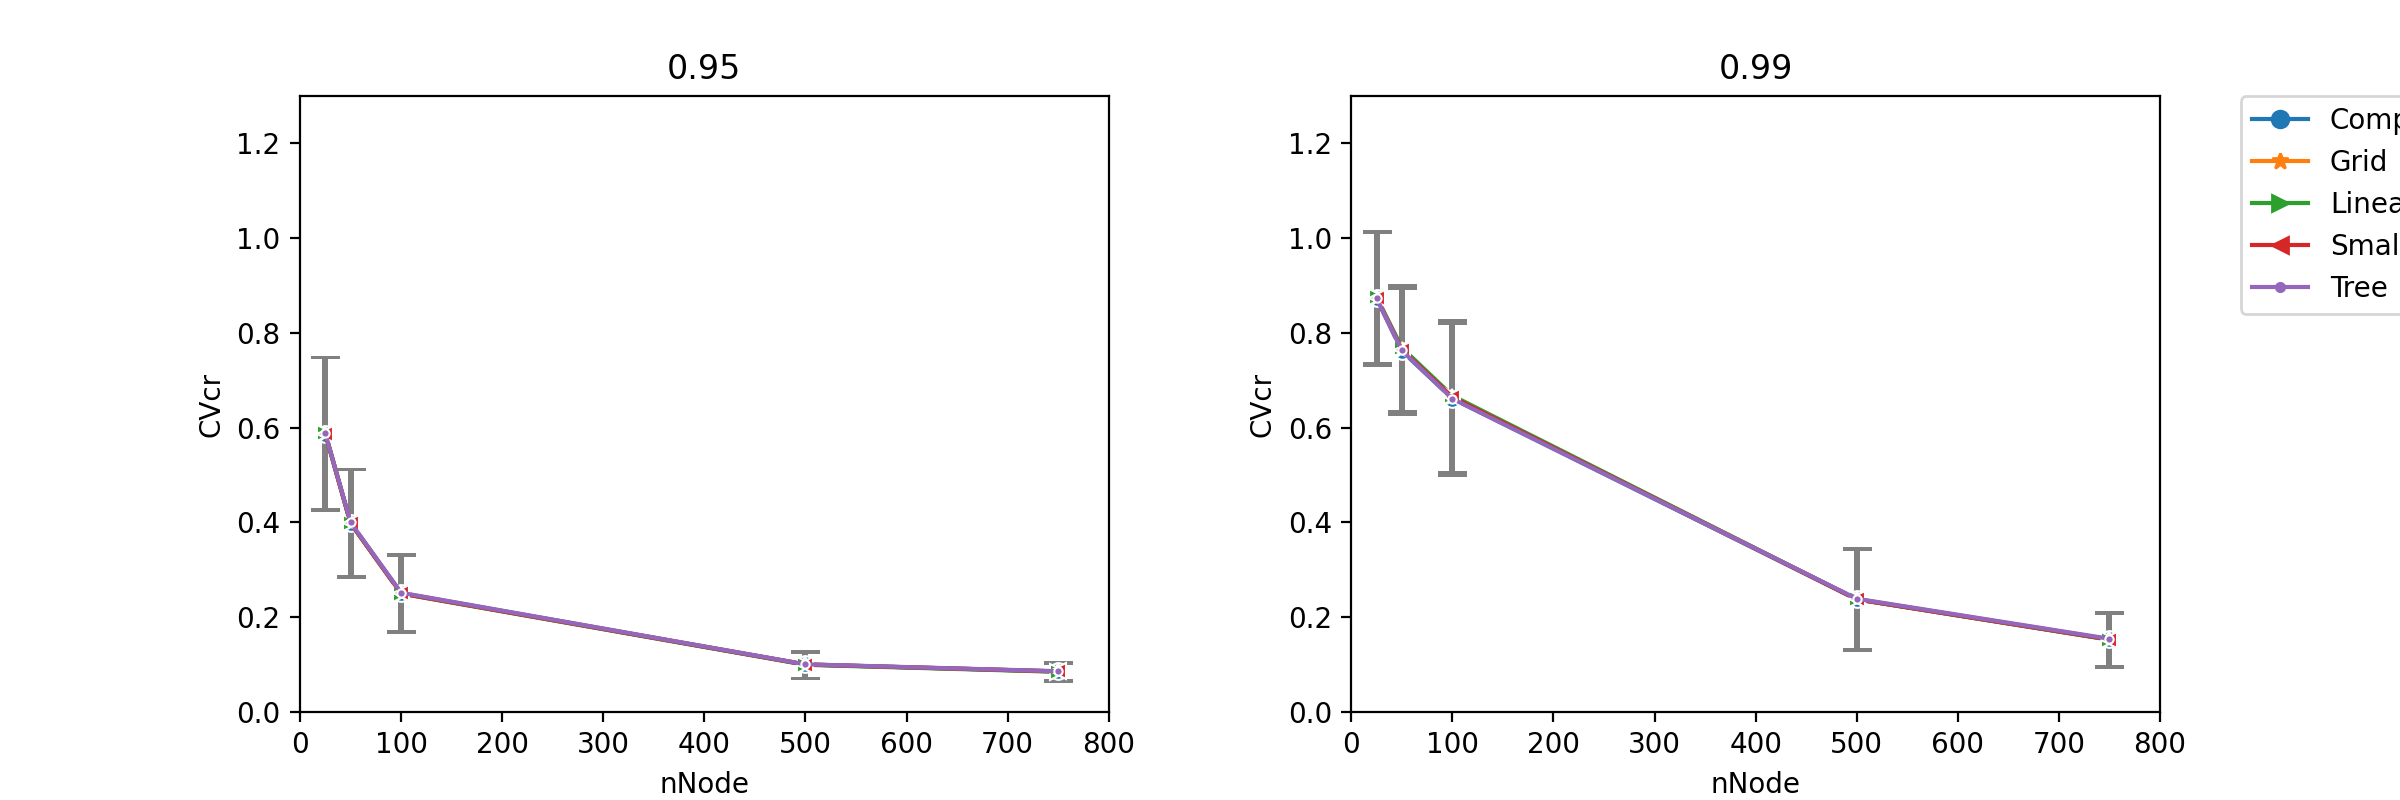

In [19]:
df = dfall.loc[(dfall.r_std==1)&(dfall.rho_eta_hetero==0.8)&(dfall.d==0.05)].groupby(['NetName','d','rho_eta_fluc','color','topology'],as_index=False).agg(np.mean)
yerrd=dfall.loc[(dfall.r_std==1)&(dfall.rho_eta_hetero==0.8)&(dfall.d==0.05)]
regPlots(df,"nNode","CVcr","rho_eta_fluc","Neutral",color='grey',yerrd=yerrd,xlim=[0,800],ylim=[0,1.3],fsize=[12,4])
# left: Figure 3(b) and Figure A1(b)

<IPython.core.display.Javascript object>


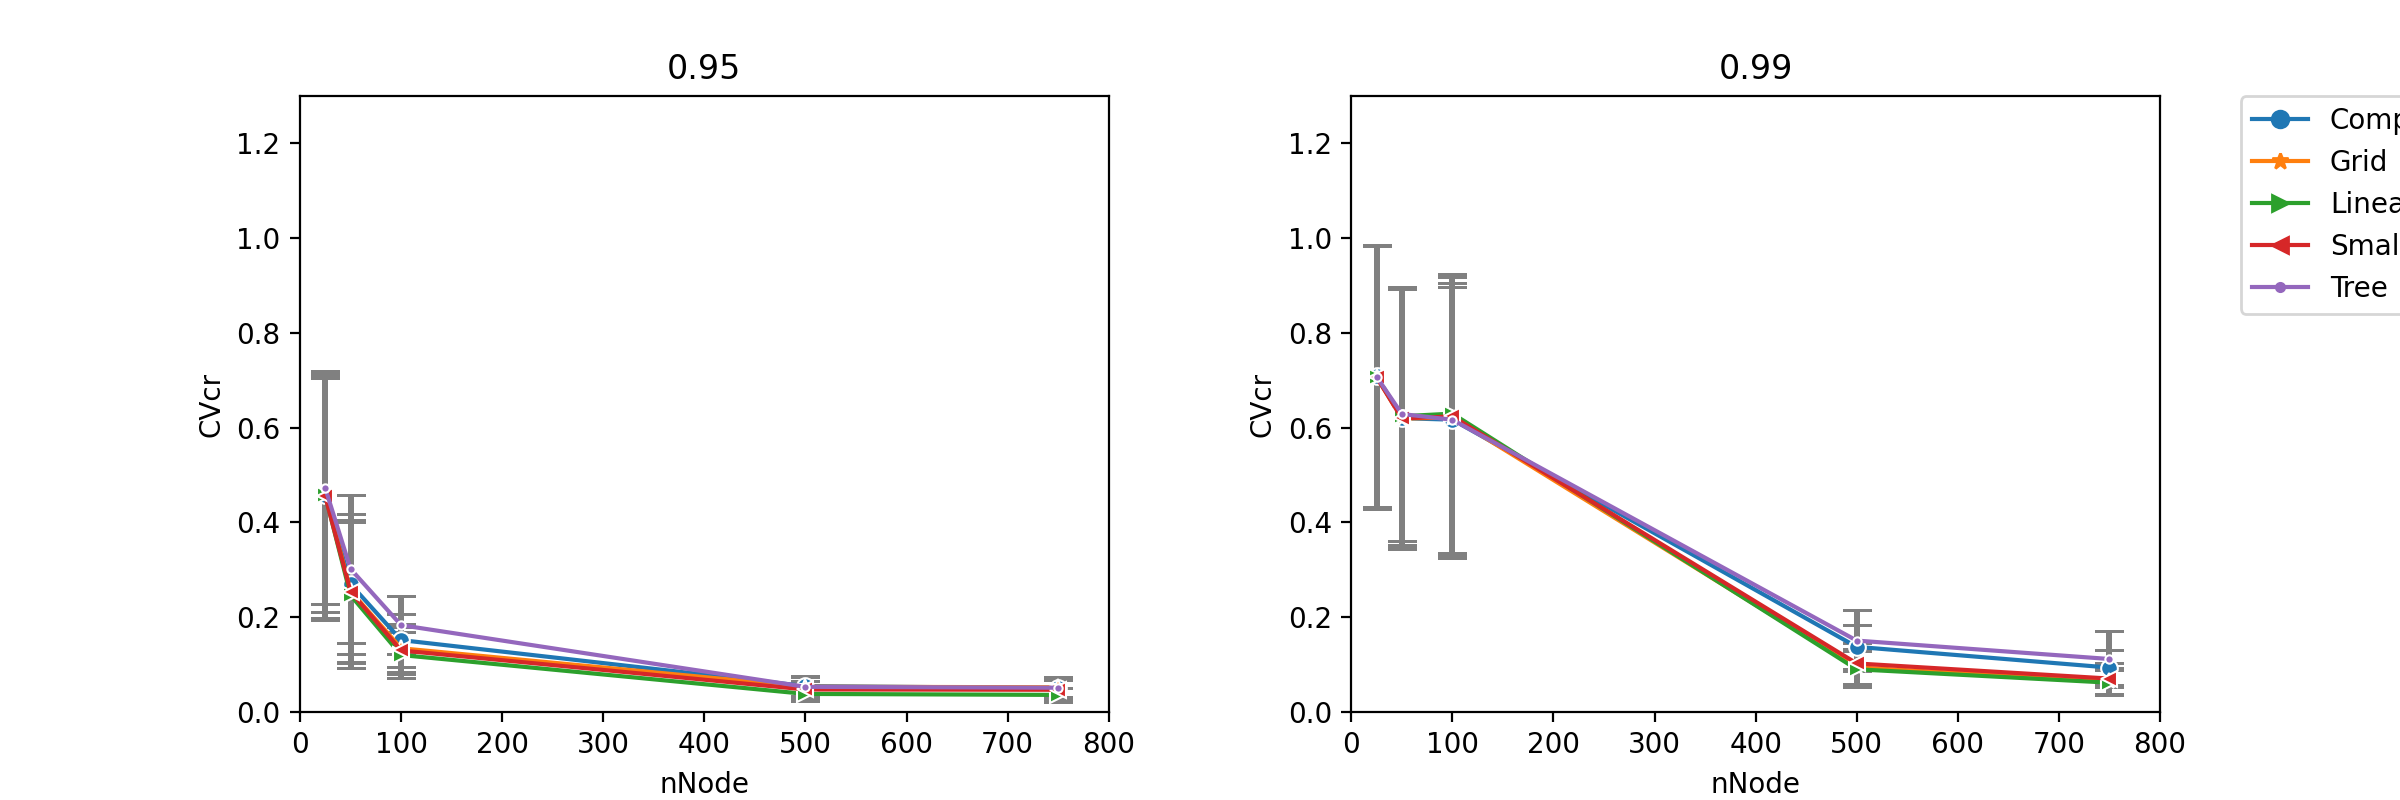

In [20]:
df = dfall.loc[(dfall.r_std==0.2)&(dfall.rho_eta_hetero==0.8)&(dfall.d==0.5)].groupby(['NetName','d','rho_eta_fluc','color','topology'],as_index=False).agg(np.mean)
yerrd=dfall.loc[(dfall.r_std==0.2)&(dfall.rho_eta_hetero==0.8)&(dfall.d==0.5)]
regPlots(df,"nNode","CVcr","rho_eta_fluc","Neutral",color='grey',yerrd=yerrd,xlim=[0,800],ylim=[0,1.3],fsize=[12,4])
# left: Figure 3(d) and Figure A1(c)

### Figure 4(b),(c)

<IPython.core.display.Javascript object>


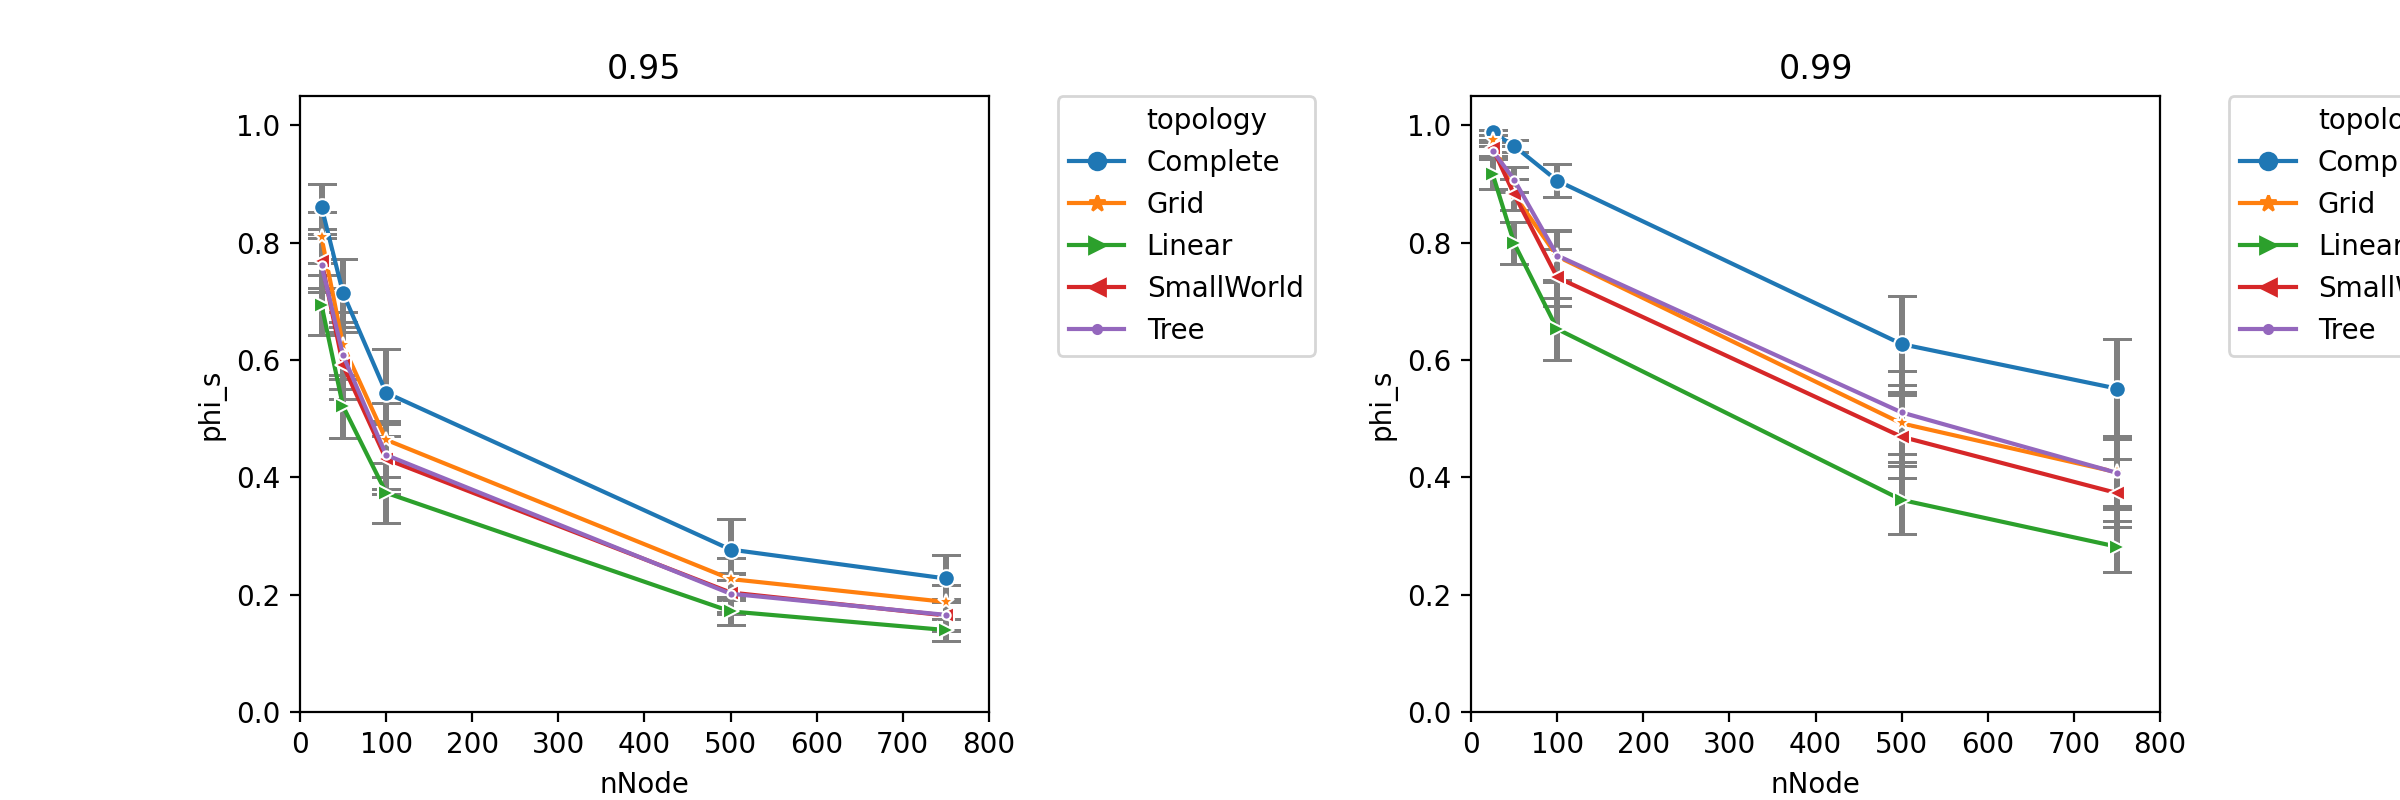

In [10]:
df = dfall.loc[(dfall.r_std==1)&(dfall.rho_eta_hetero==0.8)&(dfall.d==0.5)].groupby(['NetName','d','rho_eta_fluc','color','topology'],as_index=False).agg(np.mean)
yerrd=dfall.loc[(dfall.r_std==1)&(dfall.rho_eta_hetero==0.8)&(dfall.d==0.5)]
regPlots(df,"nNode","phi_s","rho_eta_fluc","Neutral",color='grey',yerrd=yerrd,xlim=[0,800],ylim=[0,1.05])
# Left: Figure 4b, right: Figure 4c

### Figure 4(e),(f)

<IPython.core.display.Javascript object>


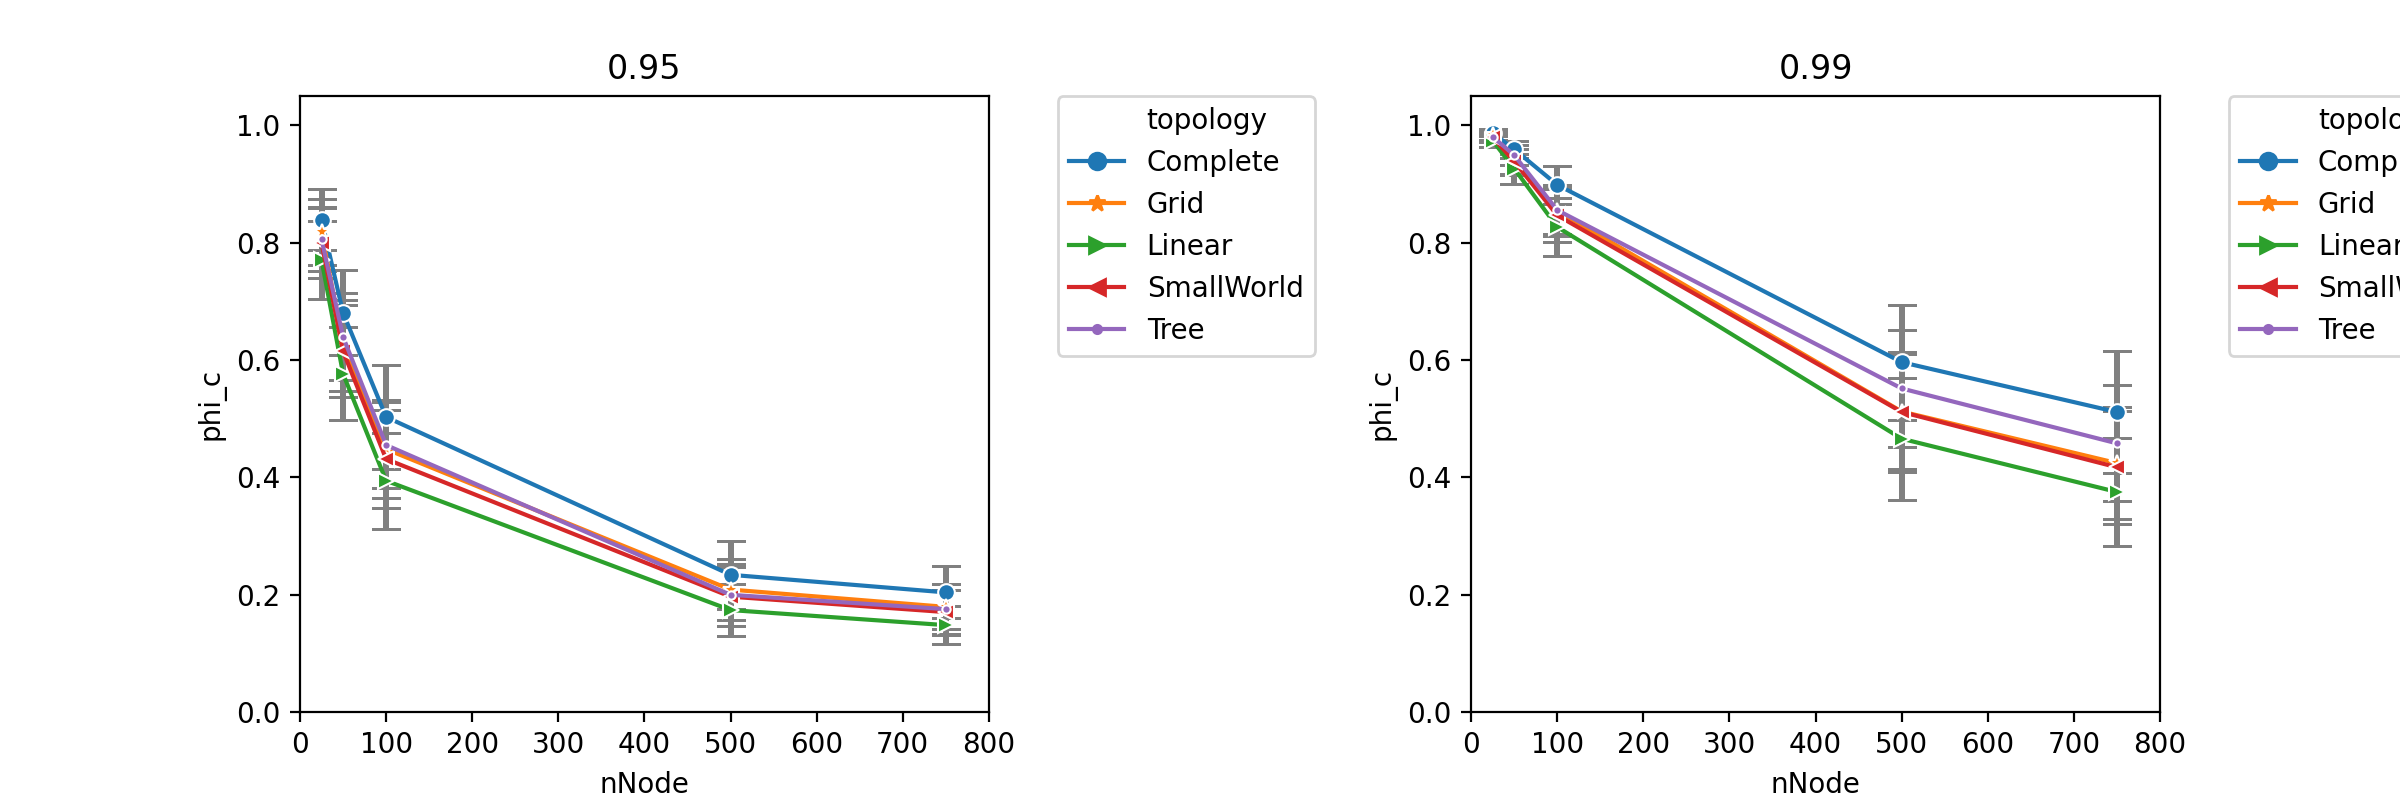

In [11]:
df = dfall.loc[(dfall.r_std==1.0)&(dfall.rho_eta_hetero==0.8)&(dfall.d==0.5)].groupby(['NetName','d','rho_eta_fluc','color','topology'],as_index=False).agg(np.mean)
yerrd=dfall.loc[(dfall.r_std==1.0)&(dfall.rho_eta_hetero==0.8)&(dfall.d==0.5)]
regPlots(df,"nNode","phi_c","rho_eta_fluc","Neutral",color='grey',yerrd=yerrd,xlim=[0,800],ylim=[0,1.05])
# left: Figure 4e, right: Figure 4f.

### Figure A3

In [12]:
#df = dfall.loc[(dfall.r_std==1.0)&(dfall.rho_eta_hetero==0.8)&(dfall.d==0.5)&(dfall.rho_eta_fluc==0.95)].groupby(['NetName'],as_index=False).agg(np.mean)
#df.to_csv("grouped_main.txt")

In [4]:
#df = dfall.loc[(dfall.r_std==1.0)&(dfall.rho_eta_hetero==0.8)&(dfall.d==0.5)&(dfall.rho_eta_fluc==0.95)]
#df.to_csv("main_std1_hetero0.8_fluc_0.95.txt")

<IPython.core.display.Javascript object>


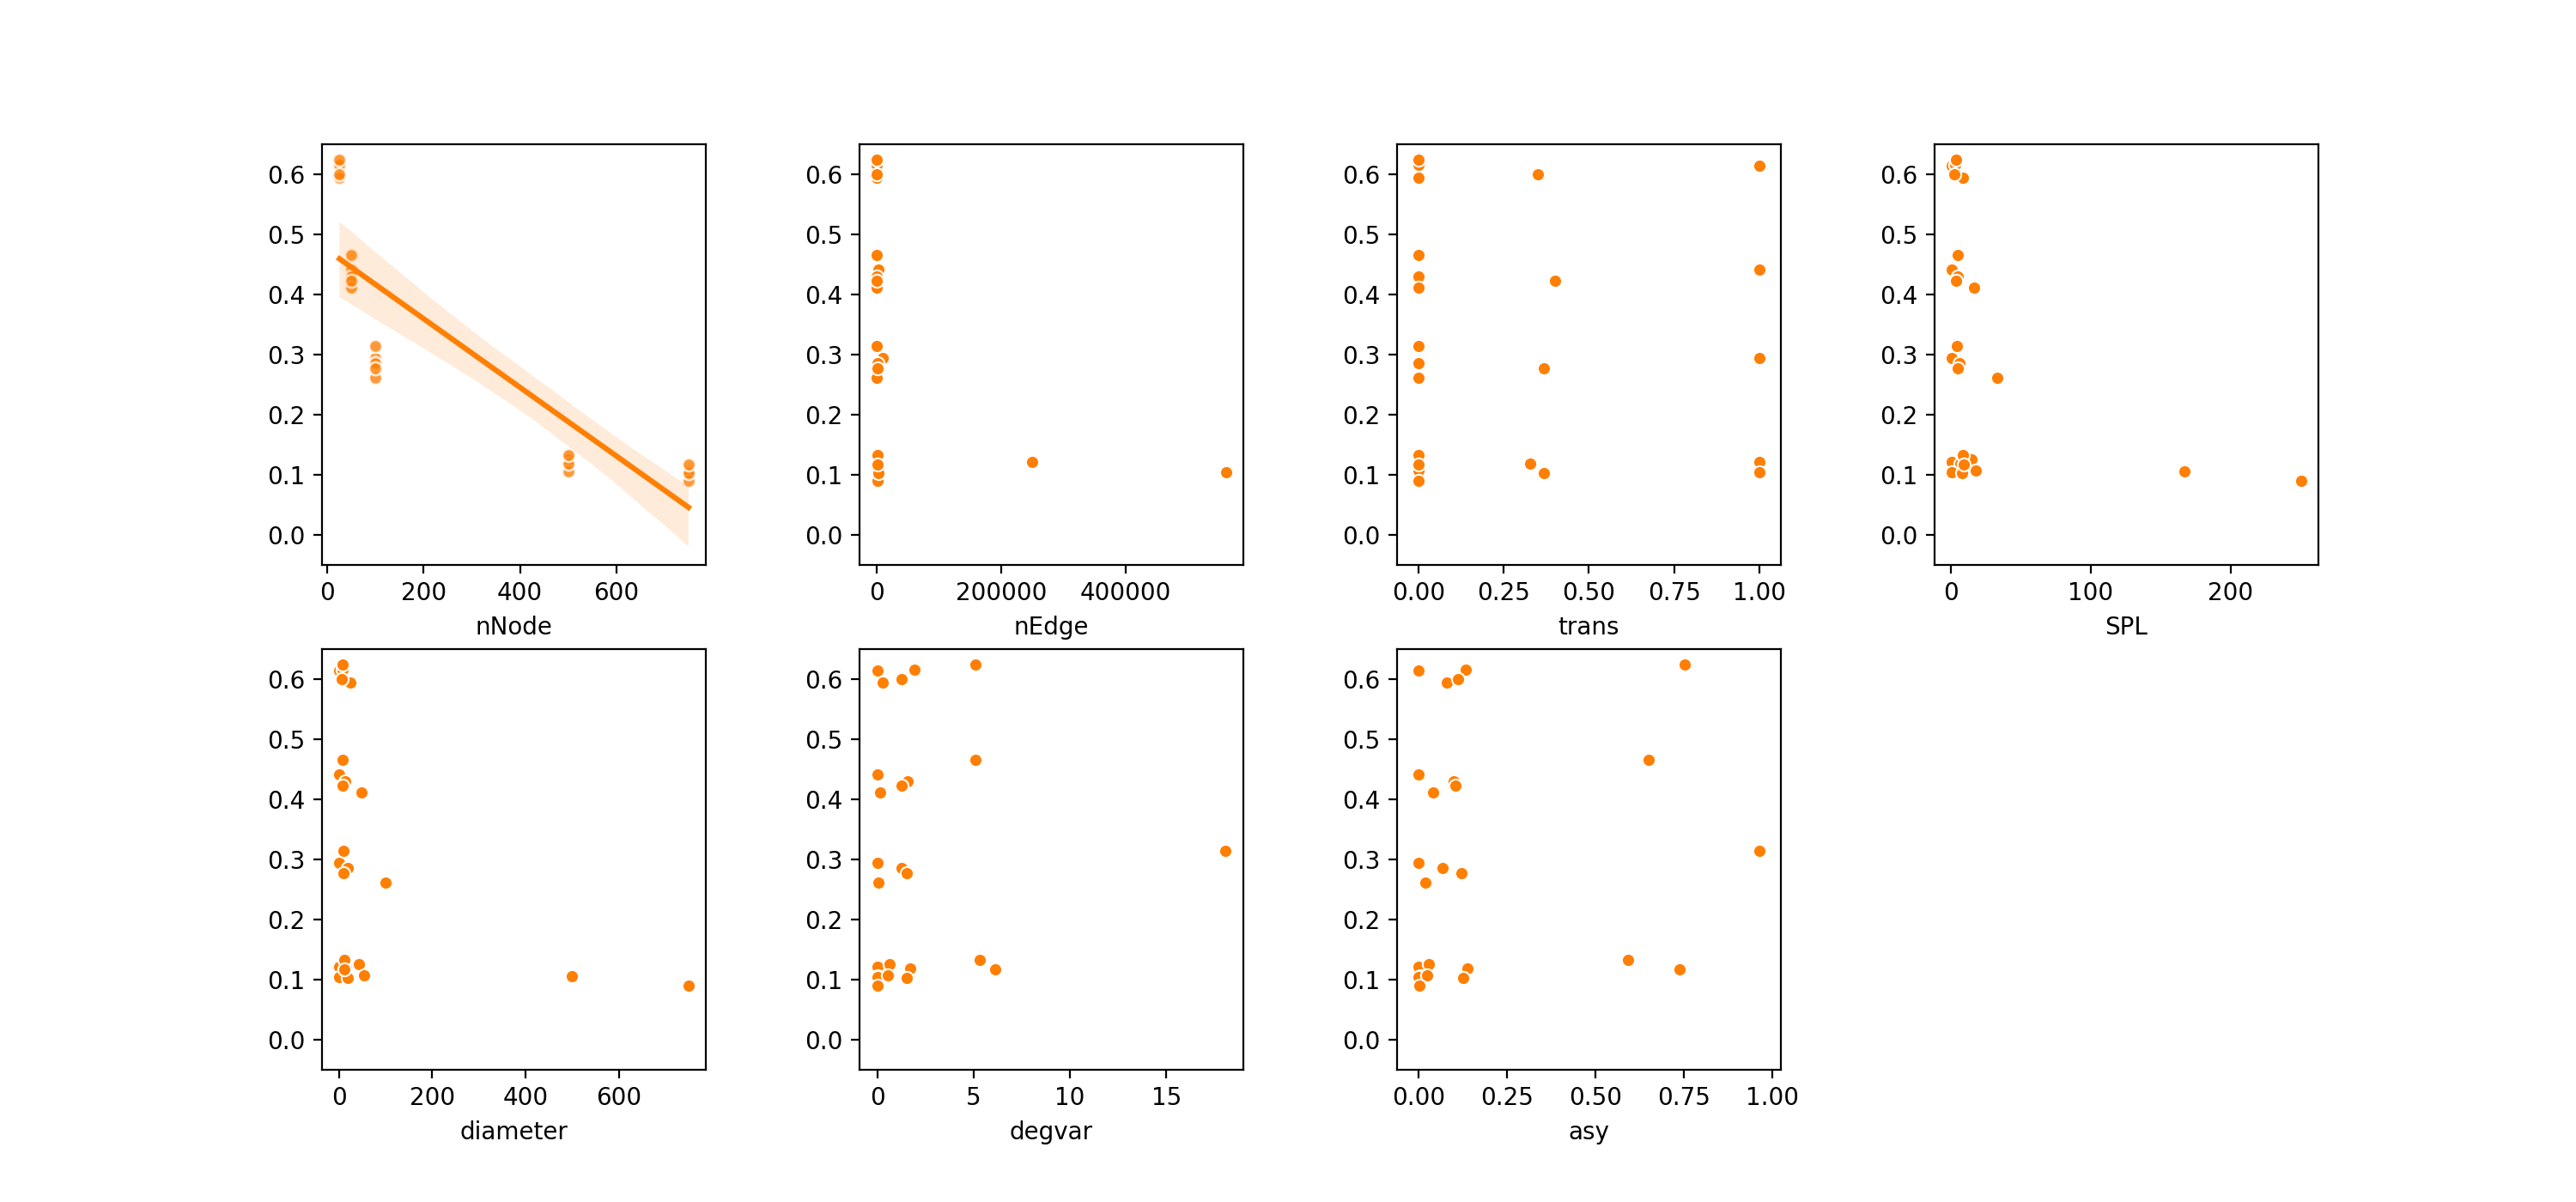

In [10]:
df = dfall.loc[(dfall.r_std==1.0)&(dfall.rho_eta_hetero==0.8)&(dfall.d==0.5)&(dfall.rho_eta_fluc==0.95)].groupby(['NetName','rho_eta_fluc','nNode'],as_index=False).agg(np.mean)
c = 1
plt.figure(figsize=[15,7])
for t in ["nNode","nEdge","trans","SPL","diameter","degvar","asy"]:
    plt.subplot(2,4,c)
    if t == "nNode":
        sns.regplot(x=t,y="CVcr",data=df,color='#ff7f03',ci=95,scatter_kws={'s':30,'edgecolors':'white'}) # with linear regression
    else:
        sns.scatterplot(x=t,y="CVcr",data=df,color='#ff7f03',s=30) # w/o linear regression
    plt.ylim([-0.05,0.65])
    c += 1
    plt.ylabel(None)
plt.subplots_adjust(wspace=0.4)
plt.show()

### Figure A4(e)

<IPython.core.display.Javascript object>


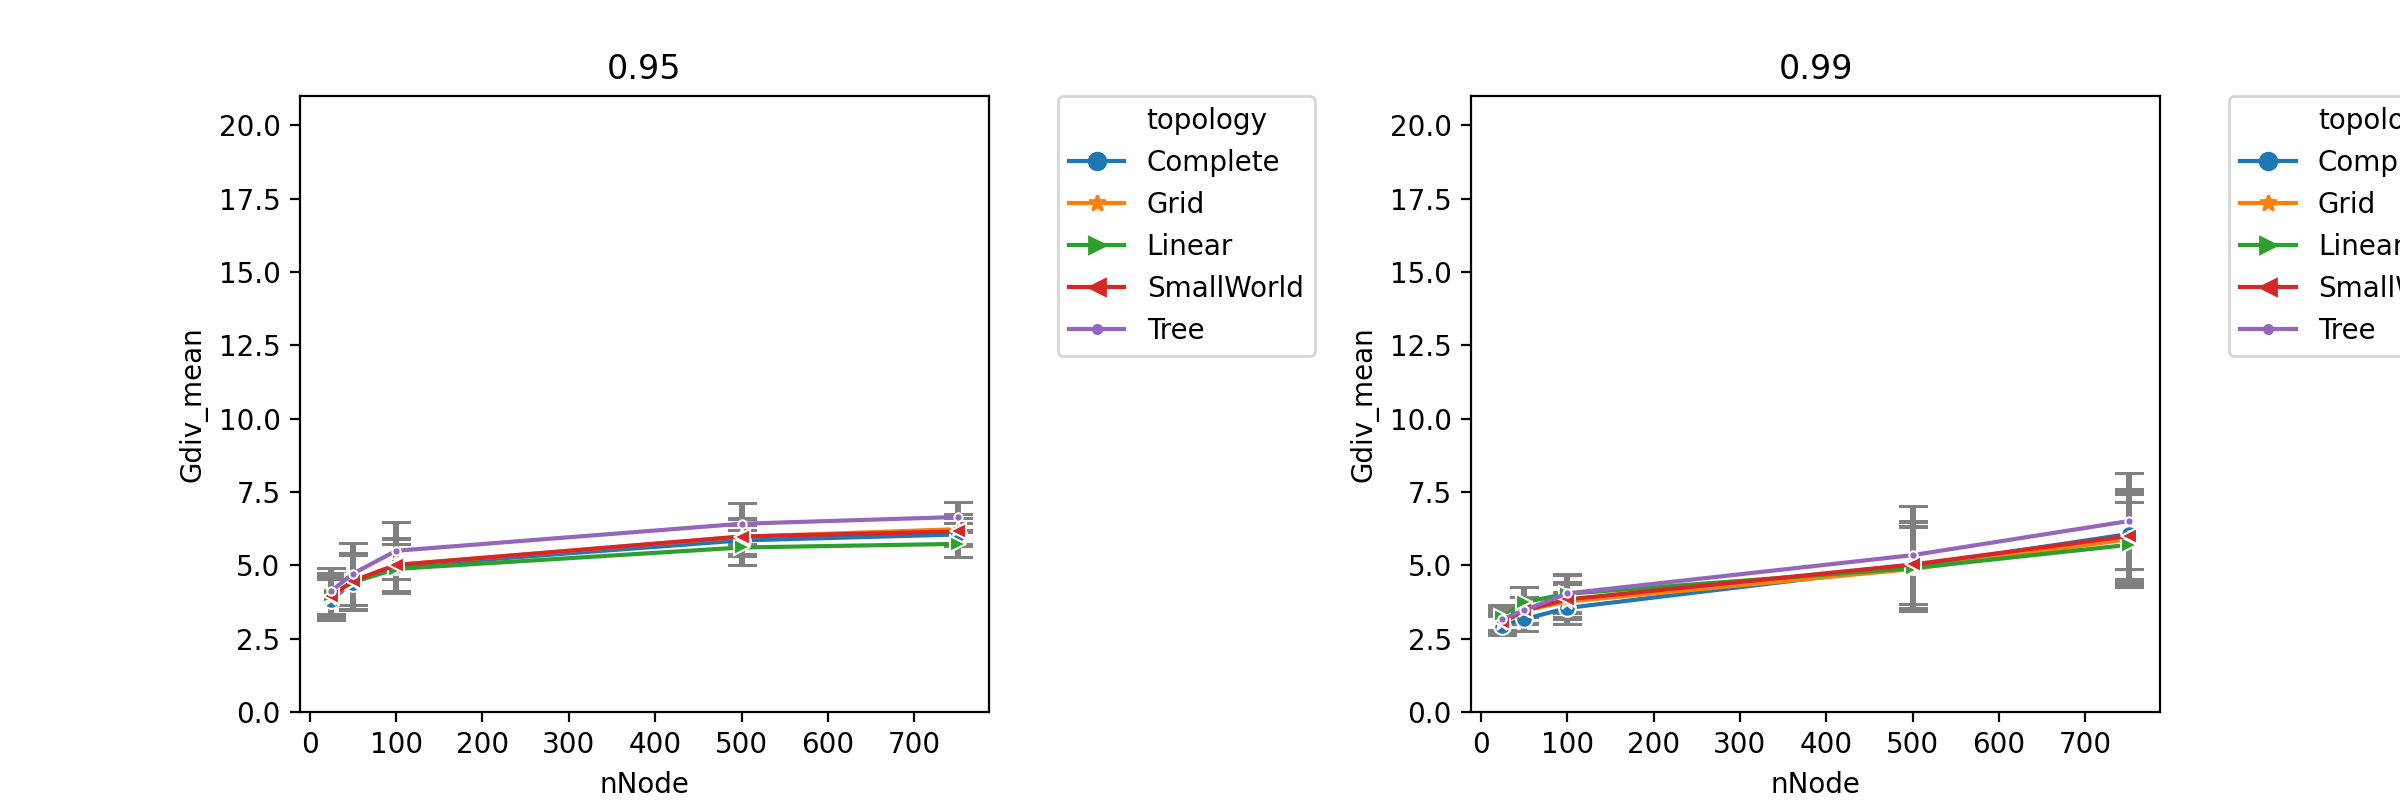

In [12]:
df = dfall.loc[(dfall.r_std==1.0)&(dfall.rho_eta_hetero==0.8)&(dfall.d==0.5)].groupby(['NetName','d','rho_eta_fluc','color','topology'],as_index=False).agg(np.mean)
yerrd=dfall.loc[(dfall.r_std==1.0)&(dfall.rho_eta_hetero==0.8)&(dfall.d==0.5)]
regPlots(df,"nNode","Gdiv_mean","rho_eta_fluc","Neutral",color='grey',yerrd=yerrd,ylim=[0,21])
# left: Figure A4(e)

### Figure A4(f)

<IPython.core.display.Javascript object>


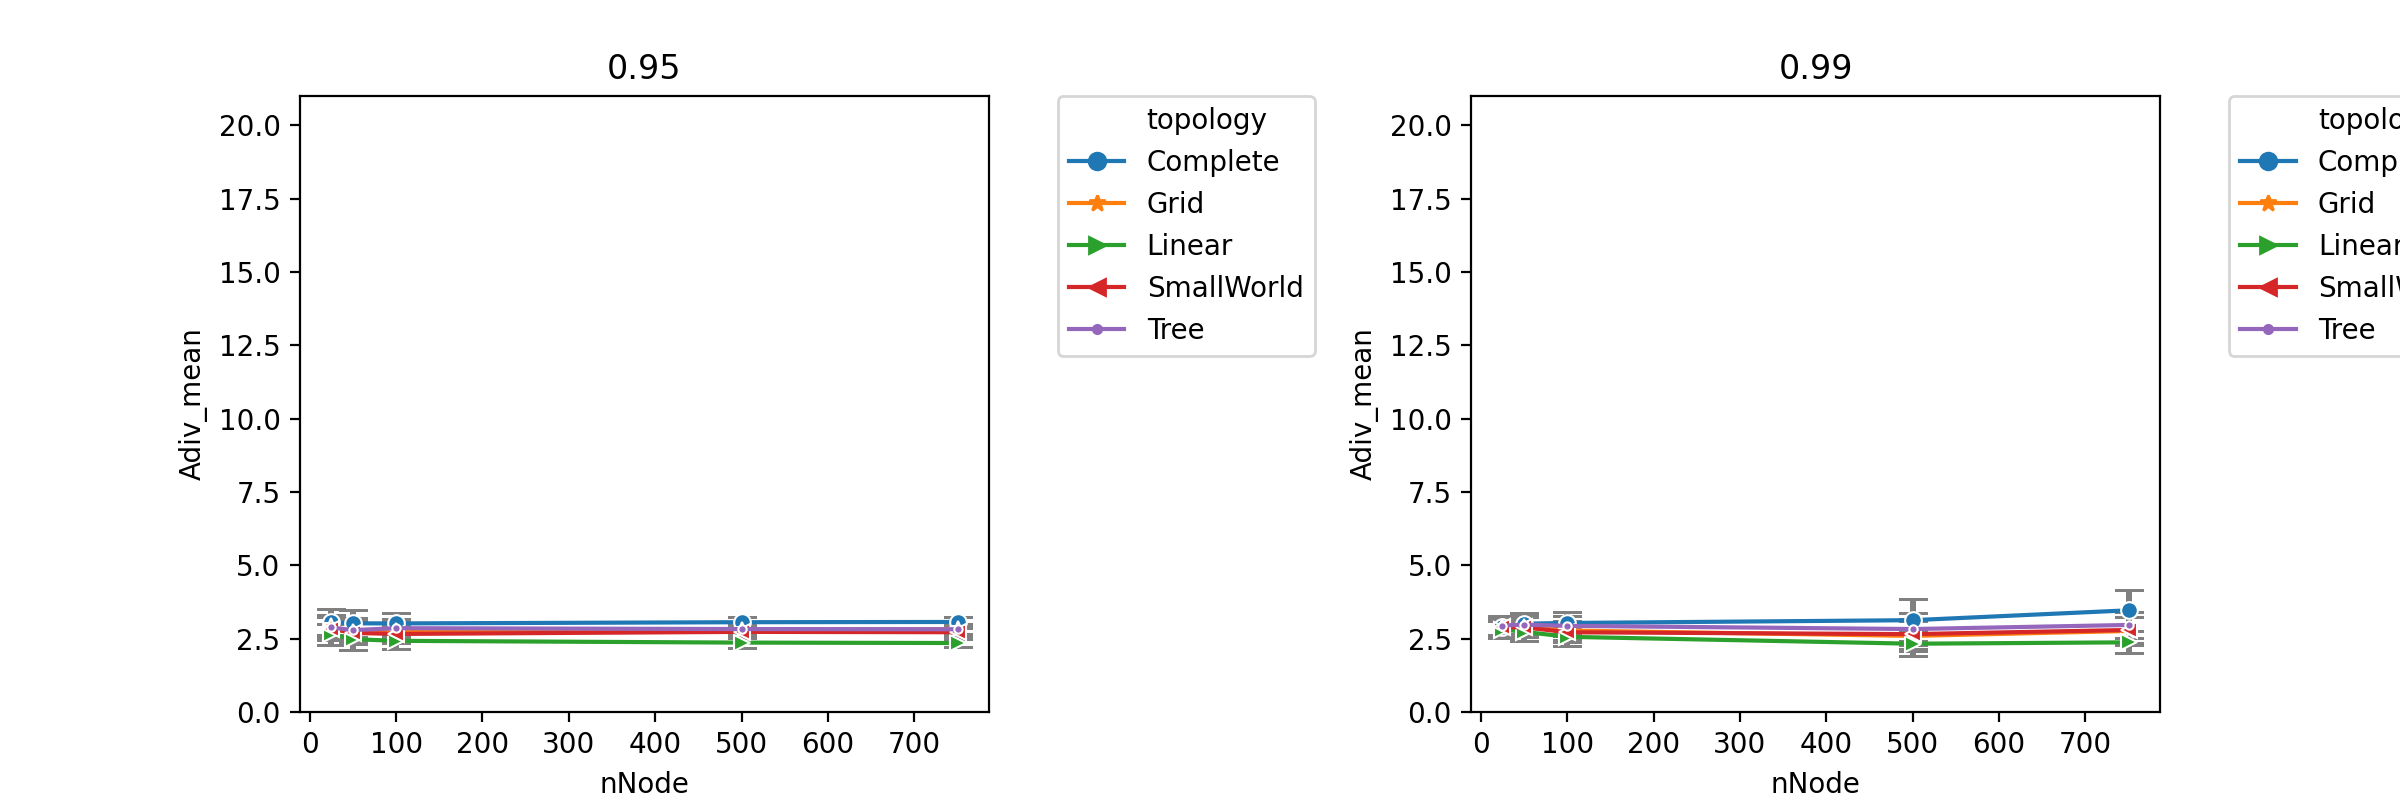

In [13]:
df = dfall.loc[(dfall.r_std==1.0)&(dfall.rho_eta_hetero==0.8)&(dfall.d==0.5)].groupby(['NetName','d','rho_eta_fluc','color','topology'],as_index=False).agg(np.mean)
yerrd=dfall.loc[(dfall.r_std==1.0)&(dfall.rho_eta_hetero==0.8)&(dfall.d==0.5)]
regPlots(df,"nNode","Adiv_mean","rho_eta_fluc","Neutral",color='grey',yerrd=yerrd,ylim=[0,21])
# left: Figure A4(f)

### Full model with symmetric interaction matrix

In [21]:
# symmetric species interaction full model
df25 = pd.read_table("WL7-4_results_wIm_2021-Mar-18/randc_2021-May-9/Results_WL7-4_5nets_N25e25_h0.1_sym_seed0.txt",delimiter=' ')
df25 = pd.merge(df25,tpl25,on='NetName')
df50 = pd.read_table("WL7-4_results_wIm_2021-Mar-18/randc_2021-May-9/Results_WL7-4_5nets_N50e50_h0.1_sym_seed0.txt",delimiter=' ')
df50 = pd.merge(df50,tpl50,on='NetName')
df100 = pd.read_table("WL7-4_results_wIm_2021-Mar-18/randc_2021-May-9/Results_WL7-4_5nets_N100e100_h0.1_sym_seed0.txt",delimiter=' ')
df100 = pd.merge(df100,tpl100,on='NetName')
df500 = pd.read_table("WL7-4_results_wIm_2021-Mar-18/randc_2021-May-9/Results_WL7-4_5nets_N500e500_h0.1_sym_seed0.txt",delimiter=' ')
df500 = pd.merge(df500,tpl500,on='NetName')
df750 = pd.read_table("WL7-4_results_wIm_2021-Mar-18/randc_2021-May-9/Results_WL7-4_5nets_N750e750_h0.1_sym_seed0.txt",delimiter=' ')
df750 = pd.merge(df750,tpl750,on='NetName')
df1 = pd.concat([df25,df50,df100,df500,df750],axis=0)
total = len(df1)
df = df1.replace([np.inf, -np.inf],np.nan).dropna()
topology = []
nNode = []
for i in df.NetName:
    name = i.split('_')[1]
    node = i.split('_')[0].split('e')[0].strip('N')
    topology.append(name)
    nNode.append(int(node))
df['topology'] = topology
df['nNode'] = nNode
pd.options.display.max_columns = df.shape[1]
dfall_sym = df.loc[df.tot_biomass!='extinction']

cols=[]
cpalette = sns.color_palette("Set2", 5)

for i in dfall_sym.topology:
    if i == "Complete":
        cols.append(cpalette[0])
    elif i == "Grid":
        cols.append(cpalette[1])
    elif i == "Linear":
        cols.append(cpalette[2])
    elif i == "SmallWorld":
        cols.append(cpalette[3])
    elif i == "Tree":
        cols.append(cpalette[4])
dfall_sym['color'] = cols

### Figure A1(m,r)

<IPython.core.display.Javascript object>


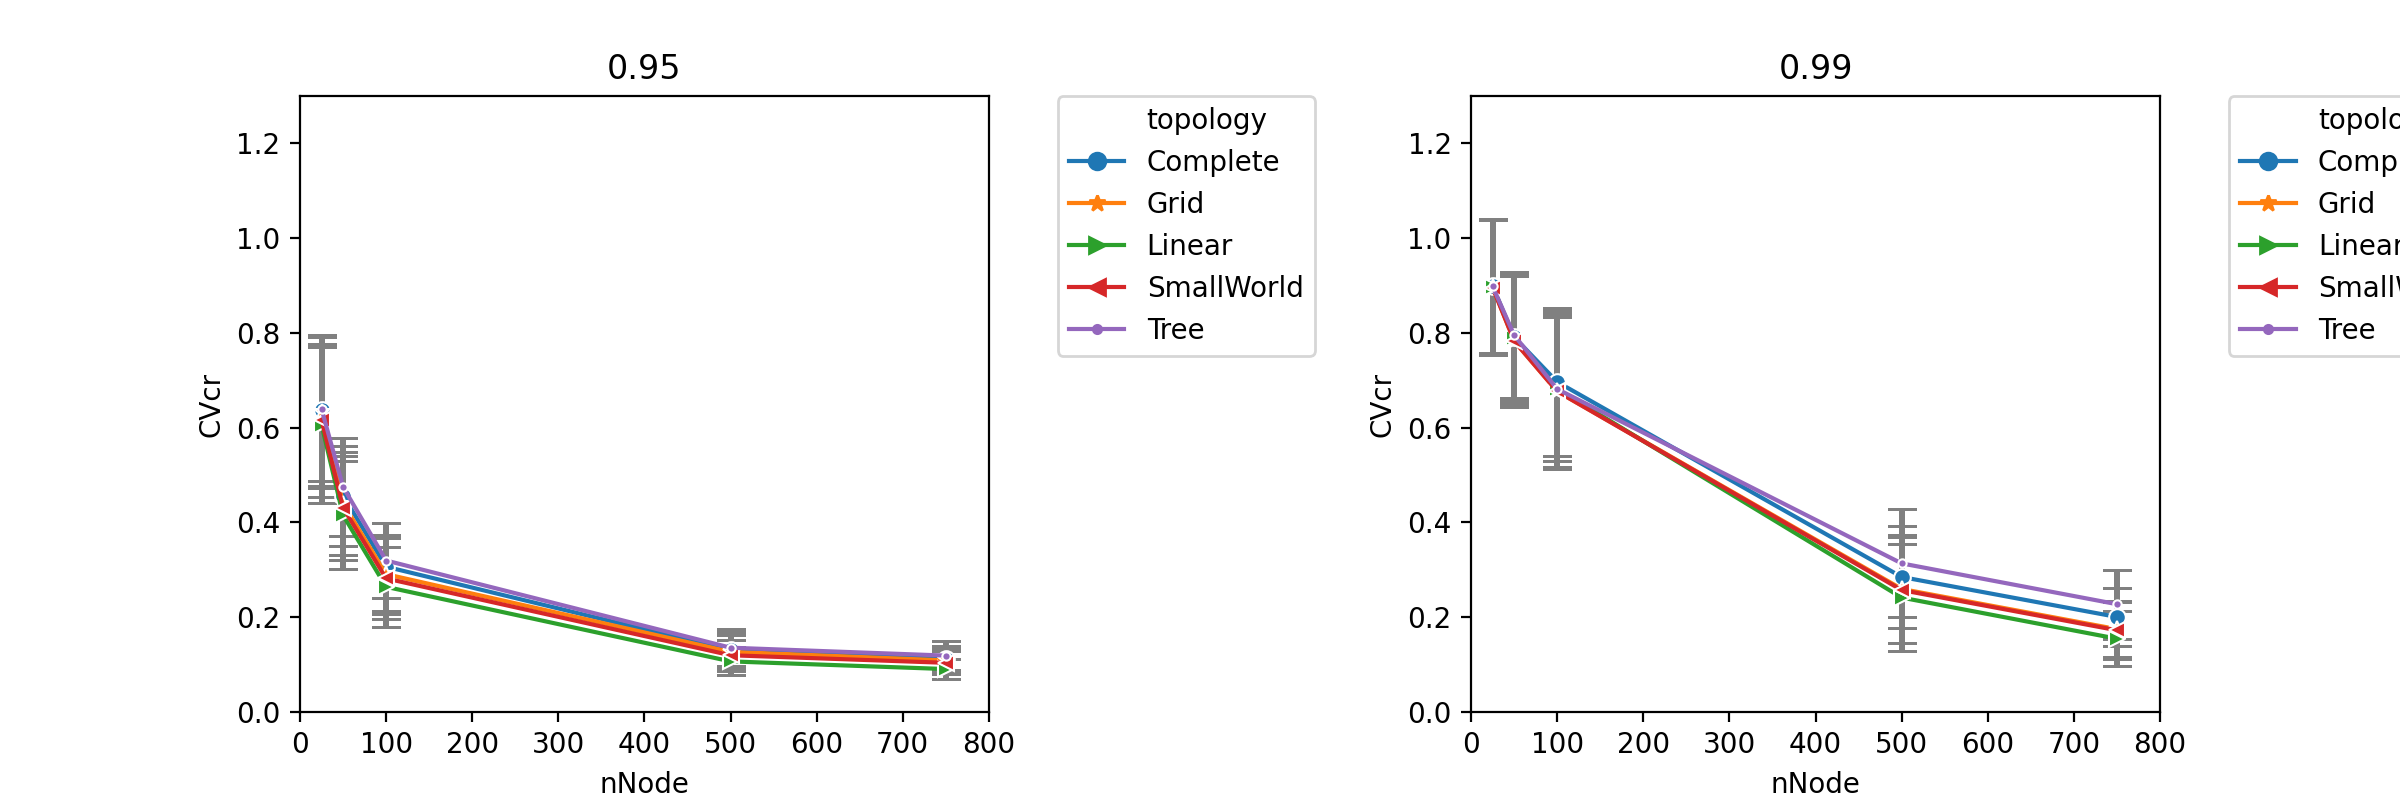

In [15]:
df = dfall_sym.loc[(dfall_sym.r_std==1.0)&(dfall_sym.rho_eta_hetero==0.8)&(dfall_sym.d==0.5)].groupby(['NetName','d','rho_eta_fluc','color','topology'],as_index=False).agg(np.mean)
yerrd=dfall_sym.loc[(dfall_sym.r_std==1.0)&(dfall_sym.rho_eta_hetero==0.8)&(dfall_sym.d==0.5)]
regPlots(df,"nNode","CVcr","rho_eta_fluc","Neutral",color='grey',yerrd=yerrd,xlim=[0,800],ylim=[0,1.3])
# left: Figure A1(m), right: Figure A1(r)

### Figure A1(n)

<IPython.core.display.Javascript object>


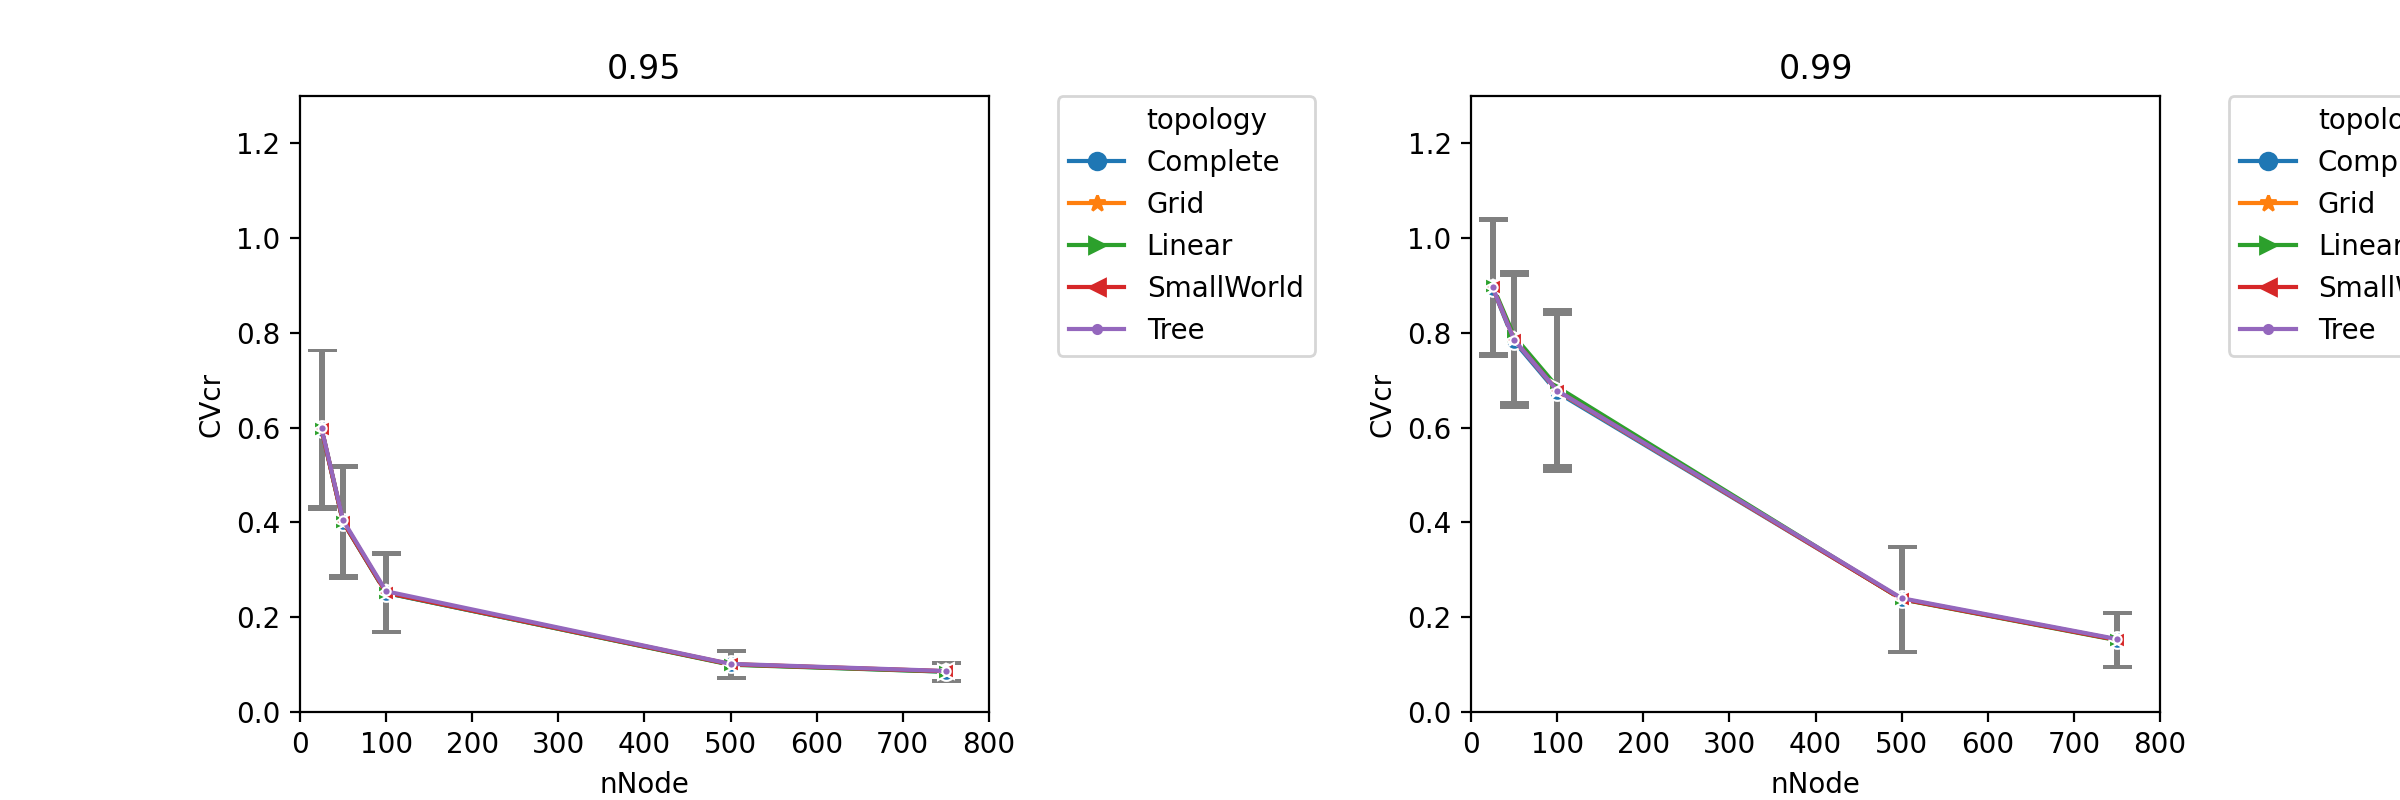

In [16]:
df = dfall_sym.loc[(dfall_sym.r_std==1.0)&(dfall_sym.rho_eta_hetero==0.8)&(dfall_sym.d==0.05)].groupby(['NetName','d','rho_eta_fluc','color','topology'],as_index=False).agg(np.mean)
yerrd=dfall_sym.loc[(dfall_sym.r_std==1.0)&(dfall_sym.rho_eta_hetero==0.8)&(dfall_sym.d==0.05)]
regPlots(df,"nNode","CVcr","rho_eta_fluc","Neutral",color='grey',yerrd=yerrd,xlim=[0,800],ylim=[0,1.3])
# left: Figure A1(n)

### Figure A1(o)

<IPython.core.display.Javascript object>


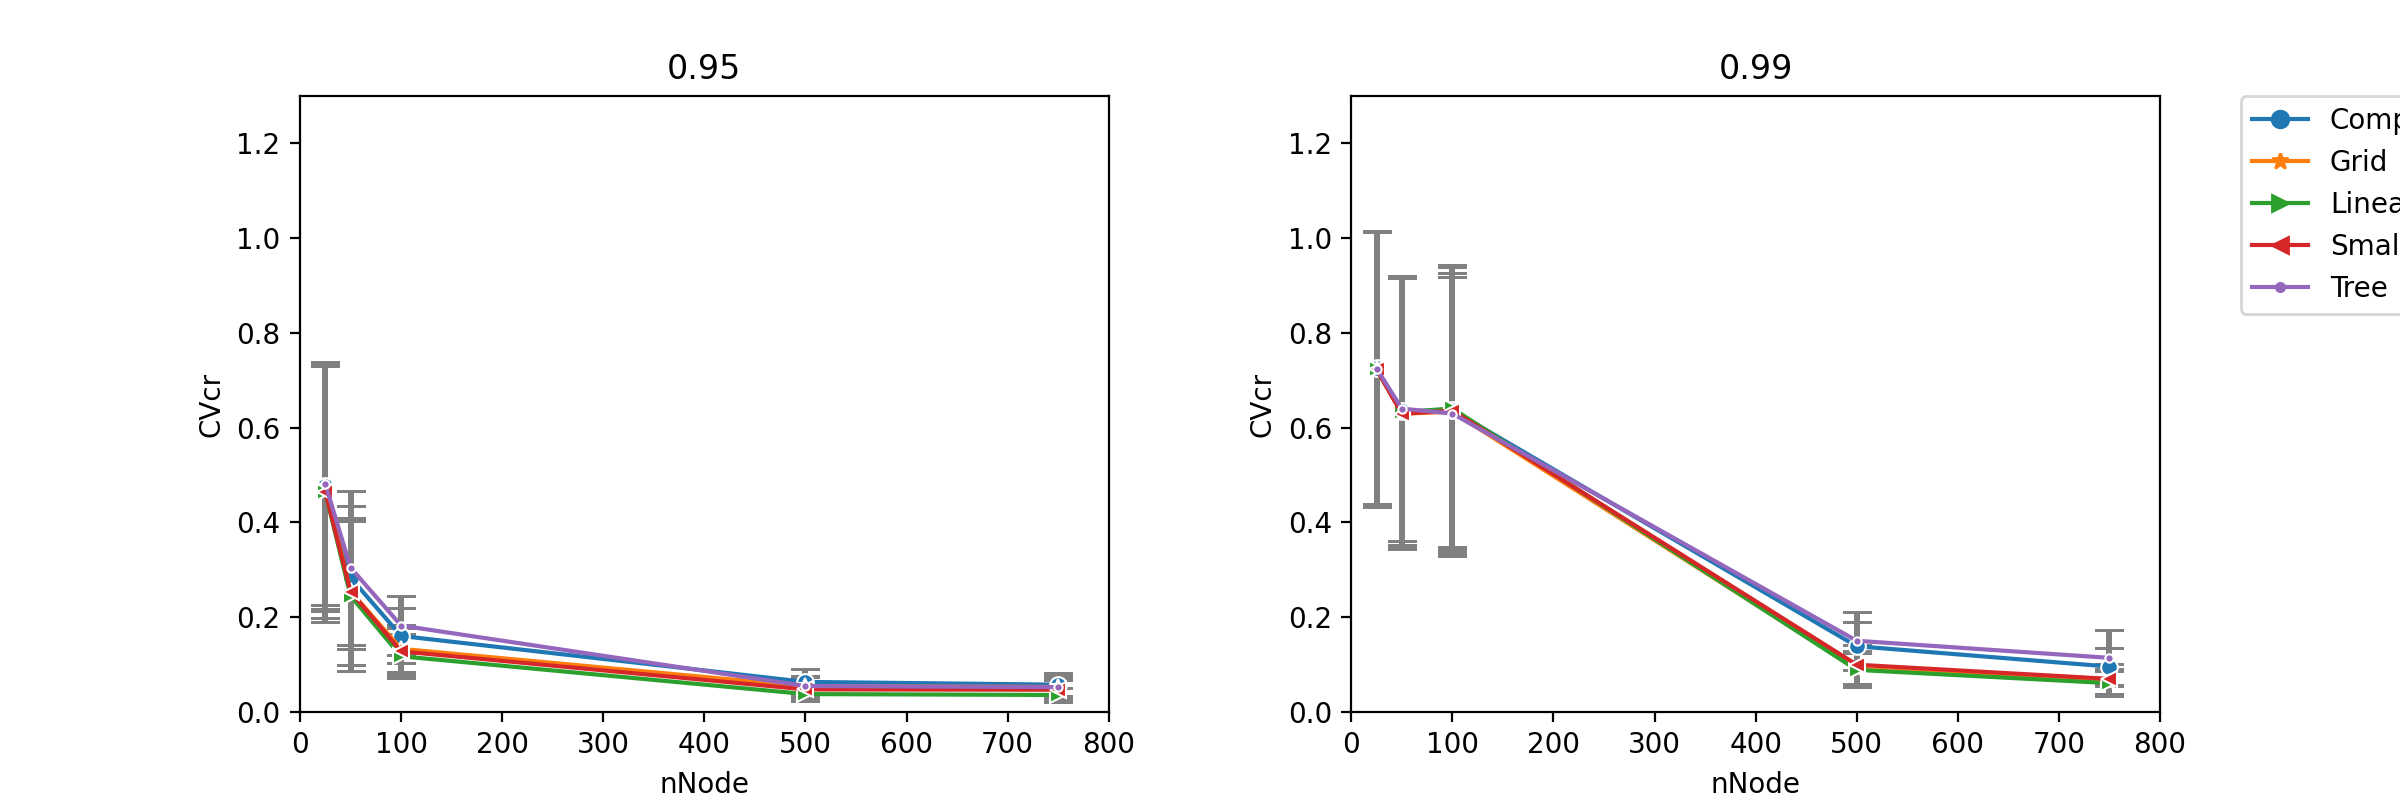

In [24]:
df = dfall_sym.loc[(dfall_sym.r_std==0.2)&(dfall_sym.rho_eta_hetero==0.8)&(dfall_sym.d==0.5)].groupby(['NetName','d','rho_eta_fluc','color','topology'],as_index=False).agg(np.mean)
yerrd=dfall_sym.loc[(dfall_sym.r_std==0.2)&(dfall_sym.rho_eta_hetero==0.8)&(dfall_sym.d==0.5)]
regPlots(df,"nNode","CVcr","rho_eta_fluc","Neutral",color='grey',yerrd=yerrd,xlim=[0,800],ylim=[0,1.3],fsize=[12,4])
# left: Figure A1(o)

### Figure A4(i, j)

<IPython.core.display.Javascript object>


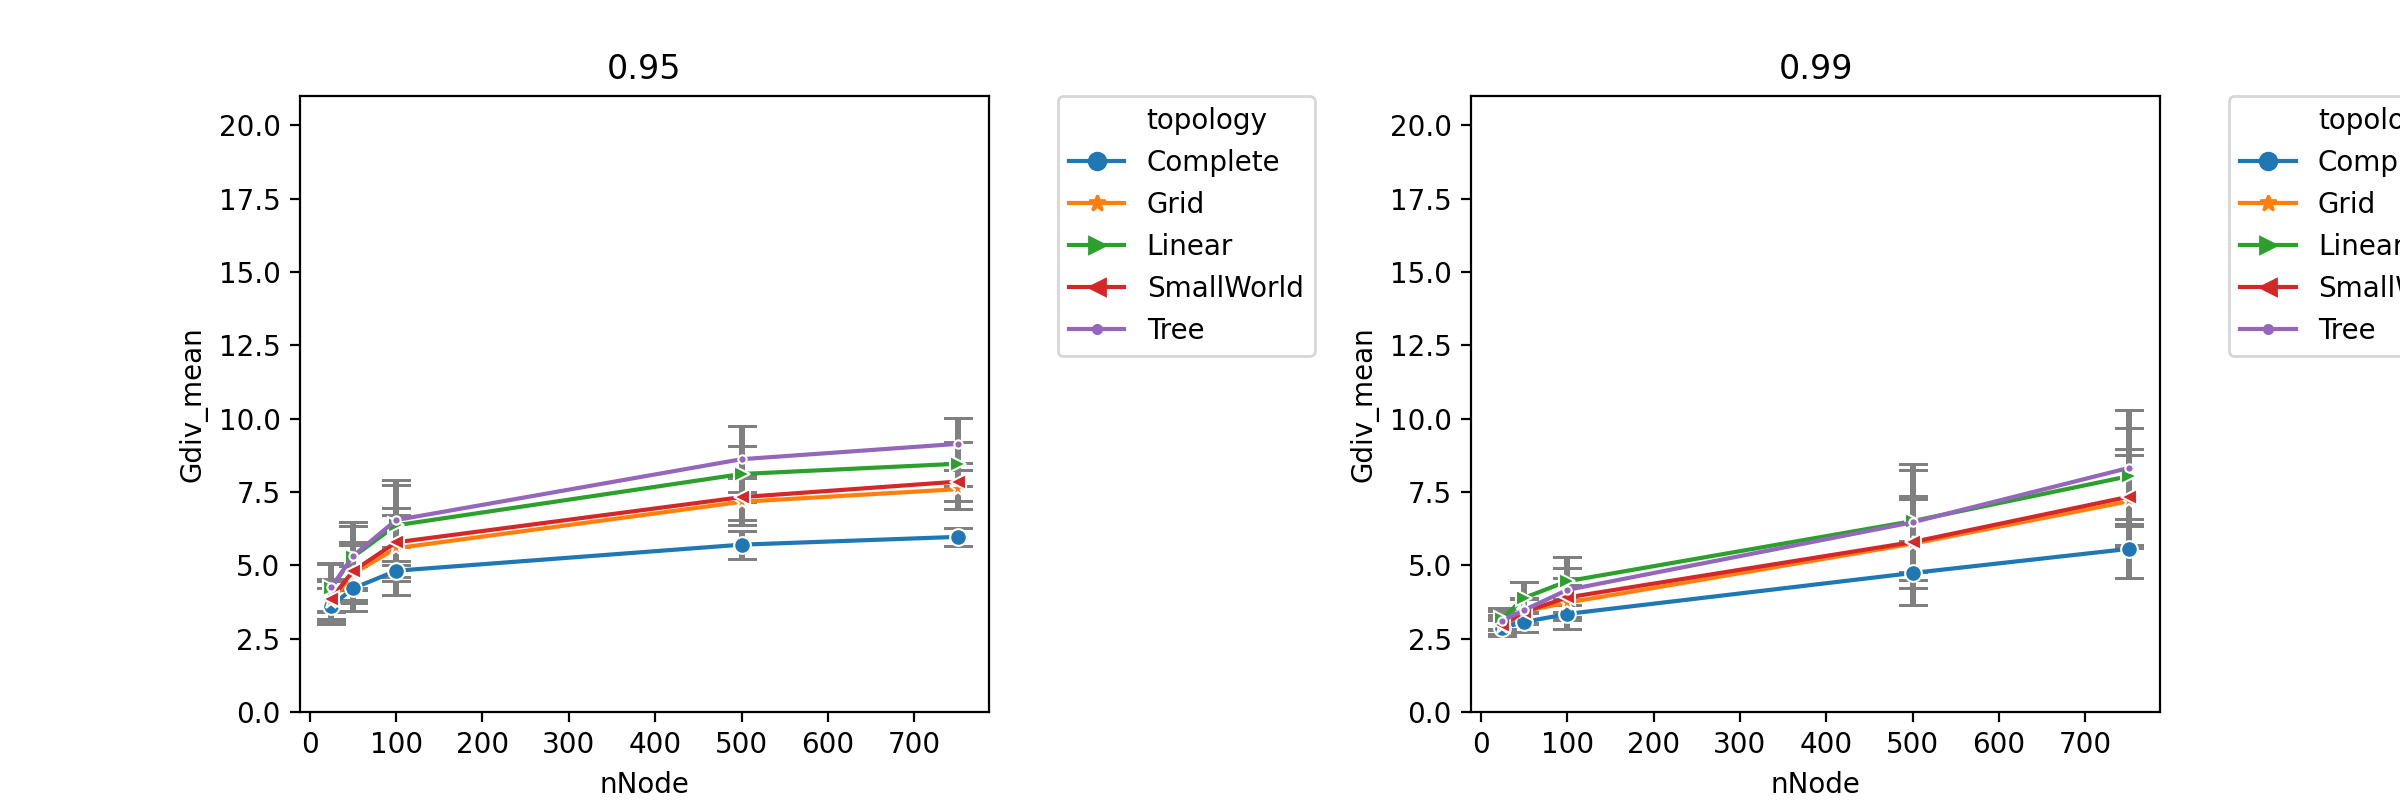

In [18]:
df = dfall_sym.loc[(dfall_sym.r_std==1.0)&(dfall_sym.rho_eta_hetero==0.8)&(dfall_sym.d==0.5)].groupby(['NetName','d','rho_eta_fluc','color','topology'],as_index=False).agg(np.mean)
yerrd=dfall_sym.loc[(dfall_sym.r_std==1.0)&(dfall_sym.rho_eta_hetero==0.8)&(dfall_sym.d==0.5)]
regPlots(df,"nNode","Gdiv_mean","rho_eta_fluc","Neutral",color='grey',yerrd=yerrd,ylim=[0,21])
# left: Figure A4(i)

<IPython.core.display.Javascript object>


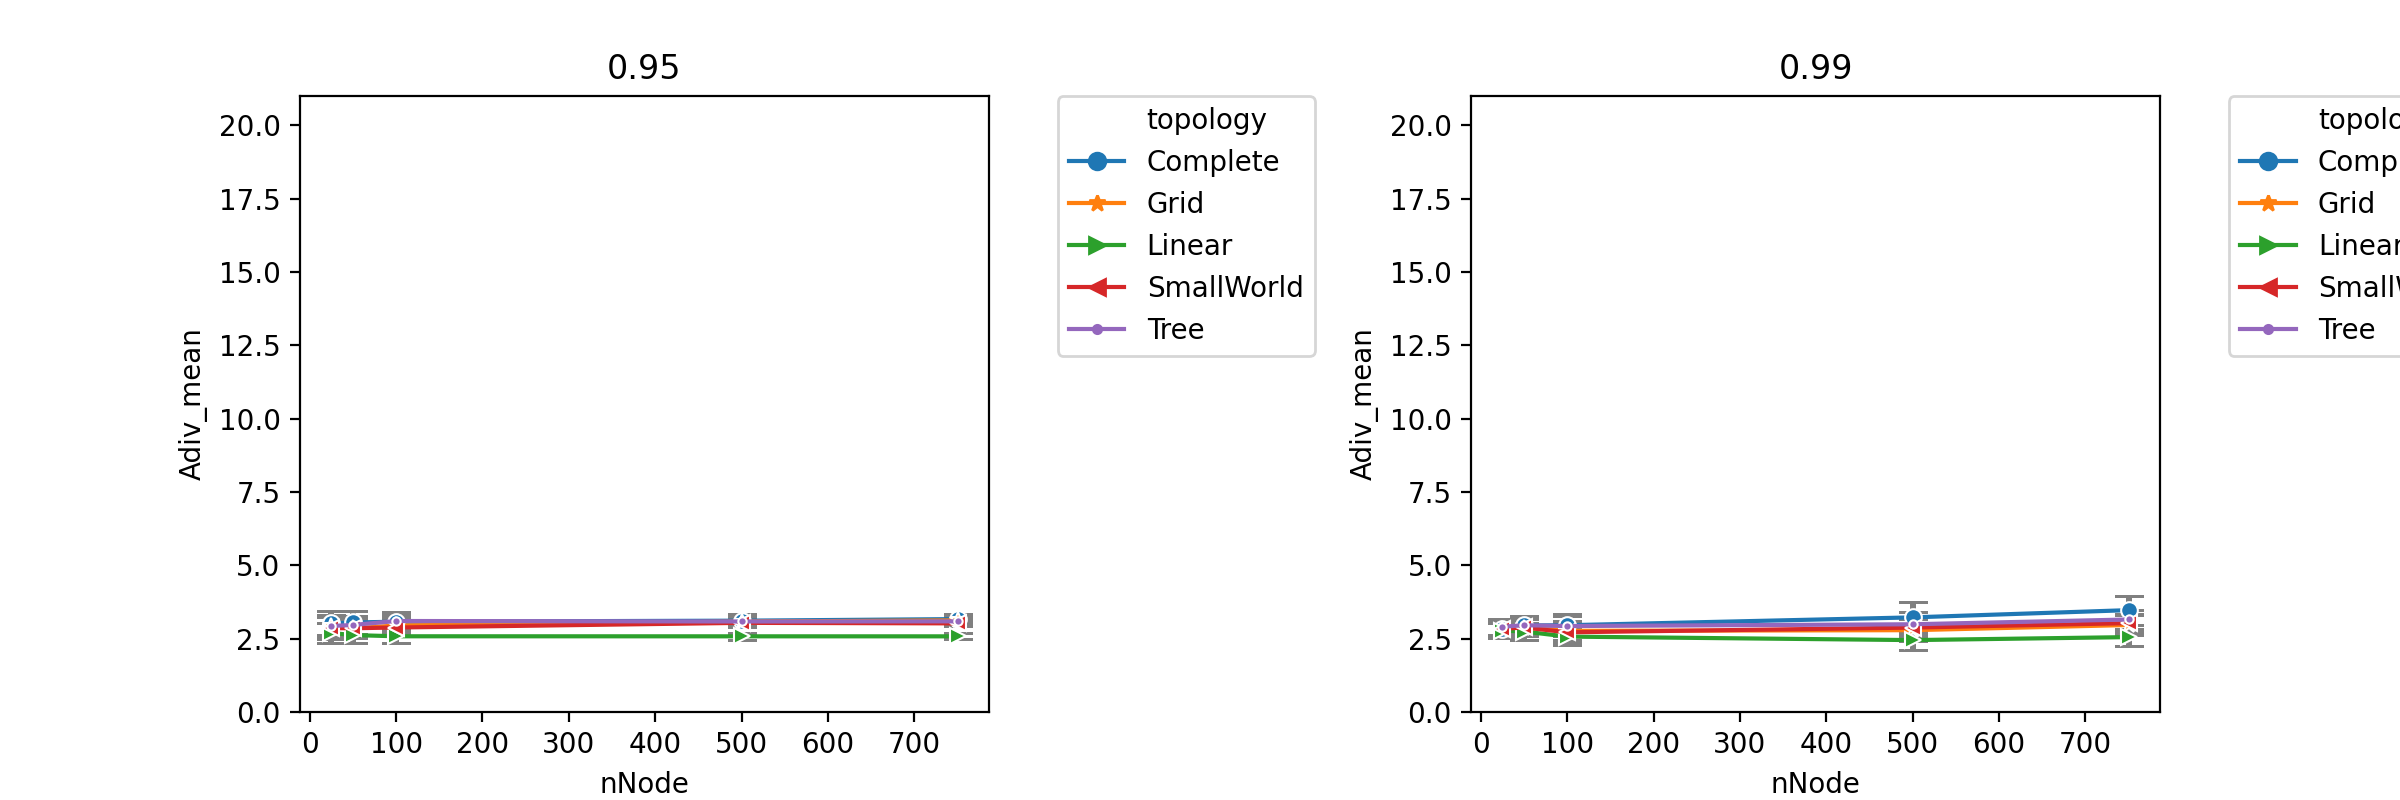

In [19]:
df = dfall_sym.loc[(dfall_sym.r_std==1.0)&(dfall_sym.rho_eta_hetero==0.8)&(dfall_sym.d==0.5)].groupby(['NetName','d','rho_eta_fluc','color','topology'],as_index=False).agg(np.mean)
yerrd=dfall_sym.loc[(dfall_sym.r_std==1.0)&(dfall_sym.rho_eta_hetero==0.8)&(dfall_sym.d==0.5)]
regPlots(df,"nNode","Adiv_mean","rho_eta_fluc","Neutral",color='grey',yerrd=yerrd,ylim=[0,21])
# left: Figure A4(j)

In [12]:
# results with asymmetric competition matrix (C)
# habitat heterogeneity controlled
df25 = pd.read_table("WL7-4_results_wIm_2021-Mar-18/randc_2021-May-9/Results_WL7-4_5nets_N25e25_h0.1_asym_seed0.txt",delimiter=' ')
df25 = pd.merge(df25,tpl25,on='NetName')
df50 = pd.read_table("WL7-4_results_wIm_2021-Mar-18/randc_2021-May-9/Results_WL7-4_5nets_N50e25_h0.1_asym_seed0.txt",delimiter=' ')
df50 = pd.merge(df50,tpl50,on='NetName')
df100 = pd.read_table("WL7-4_results_wIm_2021-Mar-18/randc_2021-May-9/Results_WL7-4_5nets_N100e25_h0.1_asym_seed0.txt",delimiter=' ')
df100 = pd.merge(df100,tpl100,on='NetName')
df500 = pd.read_table("WL7-4_results_wIm_2021-Mar-18/randc_2021-May-9/Results_WL7-4_5nets_N500e25_h0.1_asym_seed0.txt",delimiter=' ')
df500 = pd.merge(df500,tpl500,on='NetName')
df750 = pd.read_table("WL7-4_results_wIm_2021-Mar-18/randc_2021-May-9/Results_WL7-4_5nets_N750e25_h0.1_asym_seed0.txt",delimiter=' ')
df750 = pd.merge(df750,tpl750,on='NetName')
df1 = pd.concat([df25,df50,df100,df500,df750],axis=0)
total = len(df1)
df = df1.replace([np.inf, -np.inf],np.nan).dropna()
topology = []
nNode = []
for i in df.NetName:
    name = i.split('_')[1]
    node = i.split('_')[0].split('e')[0].strip('N')
    topology.append(name)
    nNode.append(int(node))
df['topology'] = topology
df['nNode'] = nNode
pd.options.display.max_columns = df.shape[1]
dfall_env_async = df.loc[df.tot_biomass!='extinction']

cols=[]
cpalette = sns.color_palette("Set2", 5)

for i in dfall_env_async.topology:
    if i == "Complete":
        cols.append(cpalette[0])
    elif i == "Grid":
        cols.append(cpalette[1])
    elif i == "Linear":
        cols.append(cpalette[2])
    elif i == "SmallWorld":
        cols.append(cpalette[3])
    elif i == "Tree":
        cols.append(cpalette[4])
dfall_env_async['color'] = cols

### Figure 3(e, g)

<IPython.core.display.Javascript object>


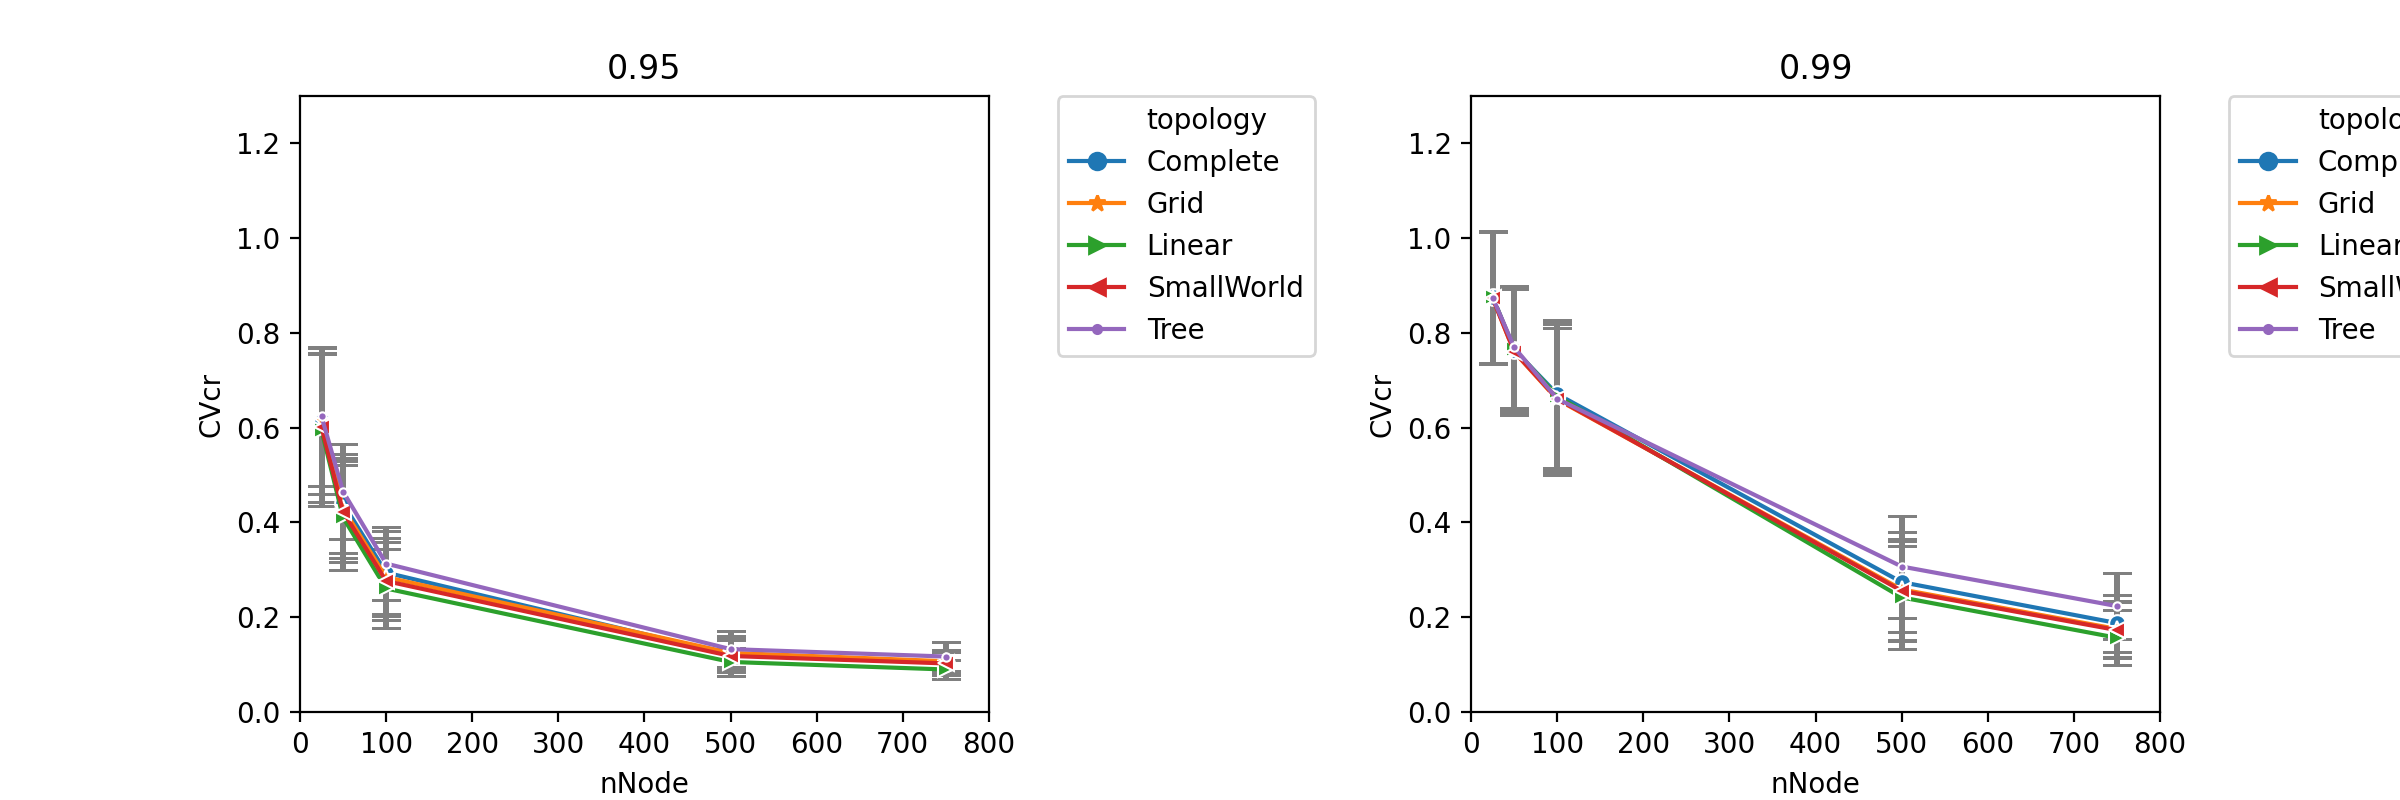

In [21]:
df = dfall_env_async.loc[(dfall_env_async.r_std==1.0)&(dfall_env_async.rho_eta_hetero==0.8)&(dfall_env_async.d==0.5)].groupby(['NetName','d','rho_eta_fluc','color','topology'],as_index=False).agg(np.mean)
yerrd=dfall_env_async.loc[(dfall_env_async.r_std==1.0)&(dfall_env_async.rho_eta_hetero==0.8)&(dfall_env_async.d==0.5)]
regPlots(df,"nNode","CVcr","rho_eta_fluc","Neutral",color='grey',yerrd=yerrd,xlim=[0,800],ylim=[0,1.3])
# left: Figure 3(e), right: Figure 3(g)

### Figure 3(f)

<IPython.core.display.Javascript object>


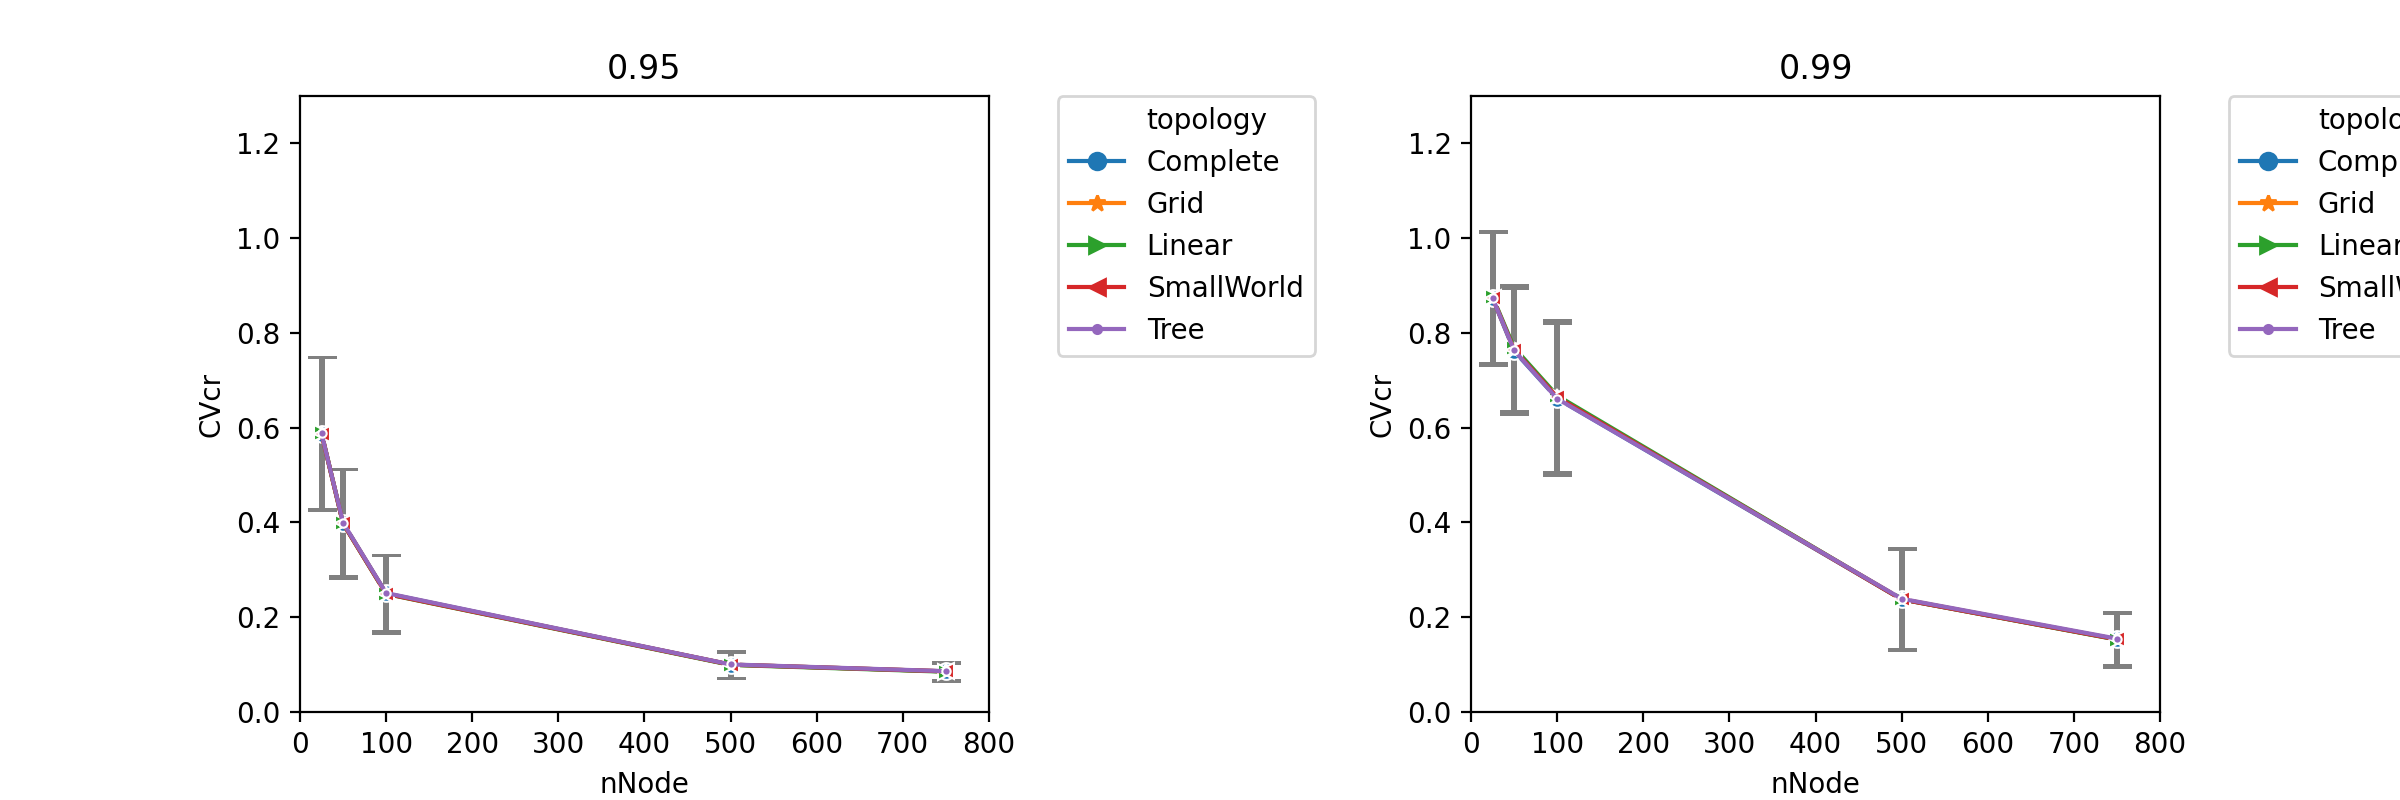

In [22]:
df = dfall_env_async.loc[(dfall_env_async.r_std==1.0)&(dfall_env_async.rho_eta_hetero==0.8)&(dfall_env_async.d==0.05)].groupby(['NetName','d','rho_eta_fluc','color','topology'],as_index=False).agg(np.mean)
yerrd=dfall_env_async.loc[(dfall_env_async.r_std==1.0)&(dfall_env_async.rho_eta_hetero==0.8)&(dfall_env_async.d==0.05)]
regPlots(df,"nNode","CVcr","rho_eta_fluc","Neutral",color='grey',yerrd=yerrd,xlim=[0,800],ylim=[0,1.3])
# left: Figure 3(f)

### Figure 3(h)

<IPython.core.display.Javascript object>


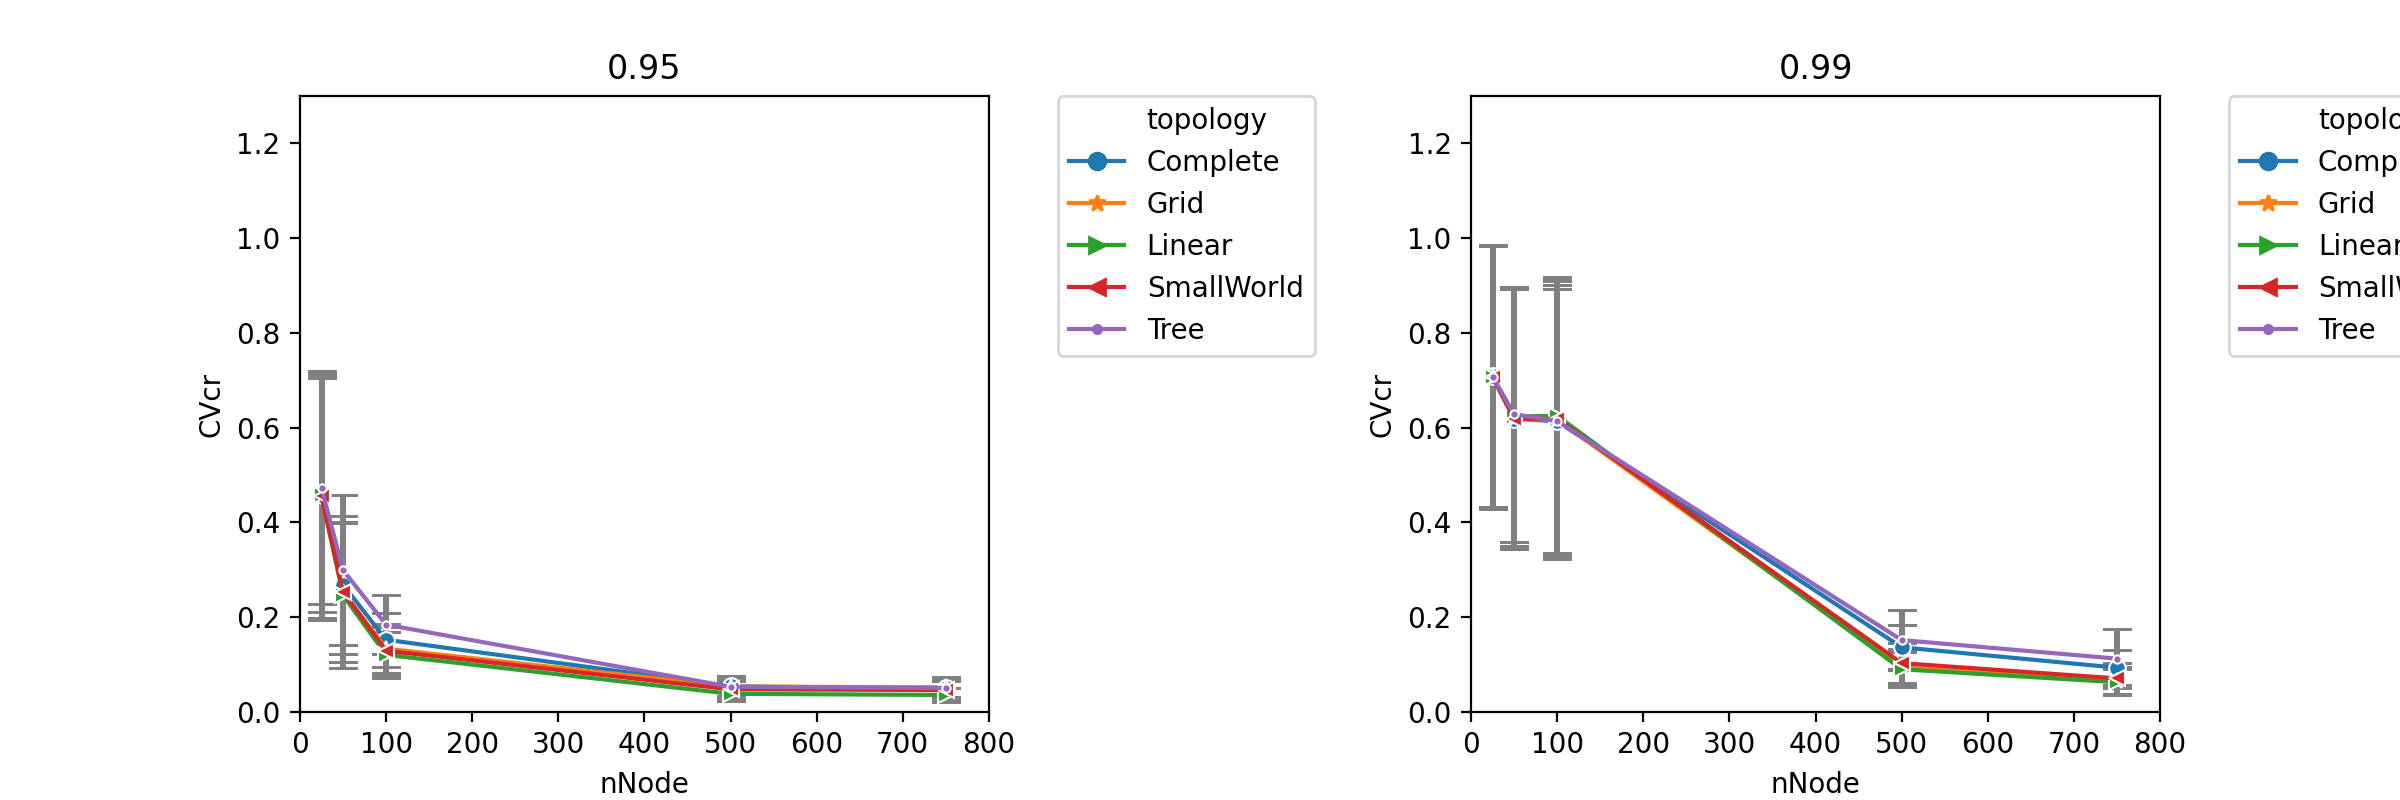

In [23]:
df = dfall_env_async.loc[(dfall_env_async.r_std==0.2)&(dfall_env_async.rho_eta_hetero==0.8)&(dfall_env_async.d==0.5)].groupby(['NetName','d','rho_eta_fluc','color','topology'],as_index=False).agg(np.mean)
yerrd=dfall_env_async.loc[(dfall_env_async.r_std==0.2)&(dfall_env_async.rho_eta_hetero==0.8)&(dfall_env_async.d==0.5)]
regPlots(df,"nNode","CVcr","rho_eta_fluc","Neutral",color='grey',yerrd=yerrd,xlim=[0,800],ylim=[0,1.3])
# left: Figure 3h

### Habitat heterogeneity and fluctuation controlled with asymmetric interaction matrix

In [6]:
df25 = pd.read_table("WL7-4_results_wIm_2021-Mar-18/synchnoise2_randc_2021-May-21/Results_WL7-4_5nets_N25e25_r0.7h0.1_synchnoise_asym_seed0.txt",delimiter=' ')
df25 = pd.merge(df25,tpl25,on='NetName')
df50 = pd.read_table("WL7-4_results_wIm_2021-Mar-18/synchnoise2_randc_2021-May-21/Results_WL7-4_5nets_N50e25_r0.7h0.1_synchnoise_asym_seed0.txt",delimiter=' ')
df50 = pd.merge(df50,tpl50,on='NetName')
df100 = pd.read_table("WL7-4_results_wIm_2021-Mar-18/synchnoise2_randc_2021-May-21/Results_WL7-4_5nets_N100e25_r0.7h0.1_synchnoise_asym_seed0.txt",delimiter=' ')
df100 = pd.merge(df100,tpl100,on='NetName')
df500 = pd.read_table("WL7-4_results_wIm_2021-Mar-18/synchnoise2_randc_2021-May-21/Results_WL7-4_5nets_N500e25_r0.7h0.1_synchnoise_asym_seed0.txt",delimiter=' ')
df500 = pd.merge(df500,tpl500,on='NetName')
df750 = pd.read_table("WL7-4_results_wIm_2021-Mar-18/synchnoise2_randc_2021-May-21/Results_WL7-4_5nets_N750e25_r0.7h0.1_synchnoise_asym_seed0.txt",delimiter=' ')
df750 = pd.merge(df750,tpl750,on='NetName')
df1 = pd.concat([df25,df50,df100,df500,df750],axis=0)
#df1 = pd.merge(df1,tpl,on='NetName')
#df1 = df1.drop(columns=['Com'])
total = len(df1)
df = df1.replace([np.inf, -np.inf],np.nan).dropna()
topology = []
nNode = []
for i in df.NetName:
    name = i.split('_')[1]
    node = i.split('_')[0].split('e')[0].strip('N')
    topology.append(name)
    nNode.append(int(node))
df['topology'] = topology
df['nNode'] = nNode
pd.options.display.max_columns = df.shape[1]
dfall_env_sync = df.loc[df.tot_biomass!='extinction']

cols=[]
cpalette = sns.color_palette("Set2", 5)

for i in dfall_env_sync.topology:
    if i == "Complete":
        cols.append(cpalette[0])
    elif i == "Grid":
        cols.append(cpalette[1])
    elif i == "Linear":
        cols.append(cpalette[2])
    elif i == "SmallWorld":
        cols.append(cpalette[3])
    elif i == "Tree":
        cols.append(cpalette[4])
dfall_env_sync['color'] = cols

### Figure 3(i), (k)

<IPython.core.display.Javascript object>


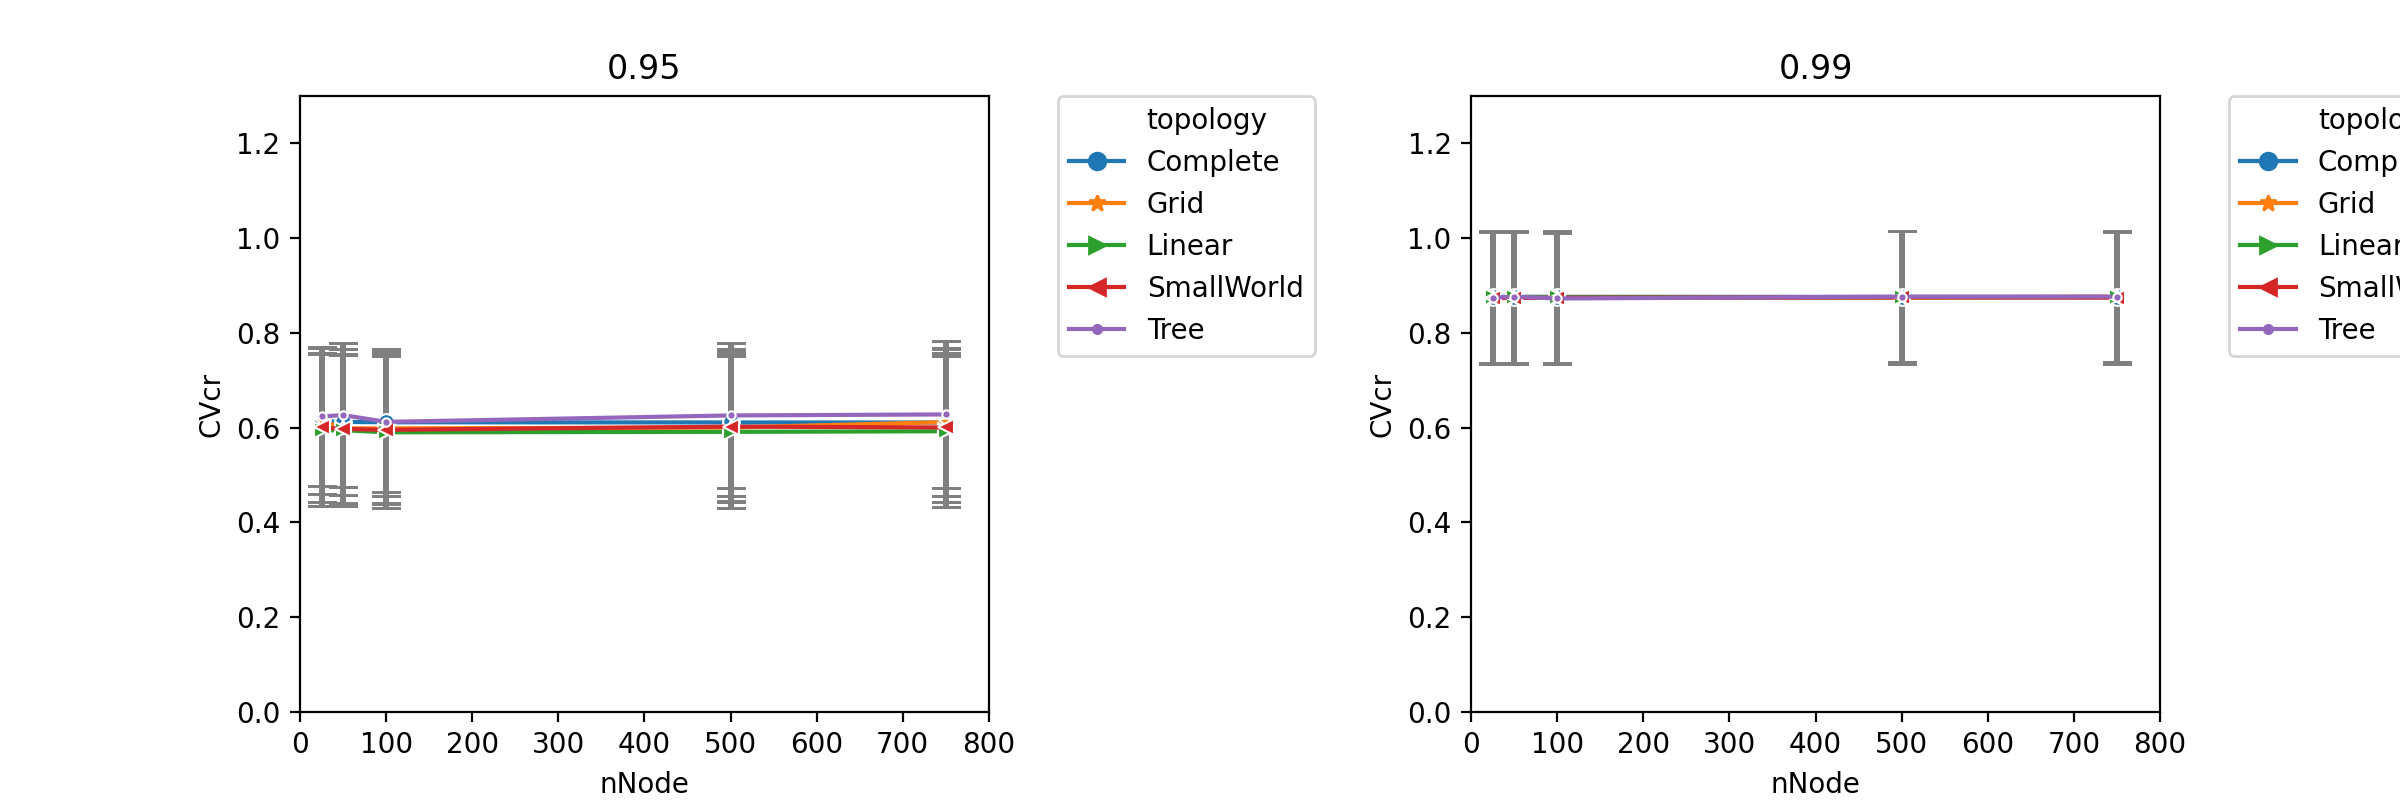

In [25]:
df = dfall_env_sync.loc[(dfall_env_sync.r_std==1.0)&(dfall_env_sync.rho_eta_hetero==0.8)&(dfall_env_sync.d==0.5)].groupby(['NetName','d','rho_eta_fluc','color','topology'],as_index=False).agg(np.mean)
yerrd=dfall_env_sync.loc[(dfall_env_sync.r_std==1.0)&(dfall_env_sync.rho_eta_hetero==0.8)&(dfall_env_sync.d==0.5)]
regPlots(df,"nNode","CVcr","rho_eta_fluc","Neutral",color='grey',yerrd=yerrd,xlim=[0,800],ylim=[0,1.3])
# left: Figure 3(i), right: Figure 3(k)

### Figure 3(j)

<IPython.core.display.Javascript object>


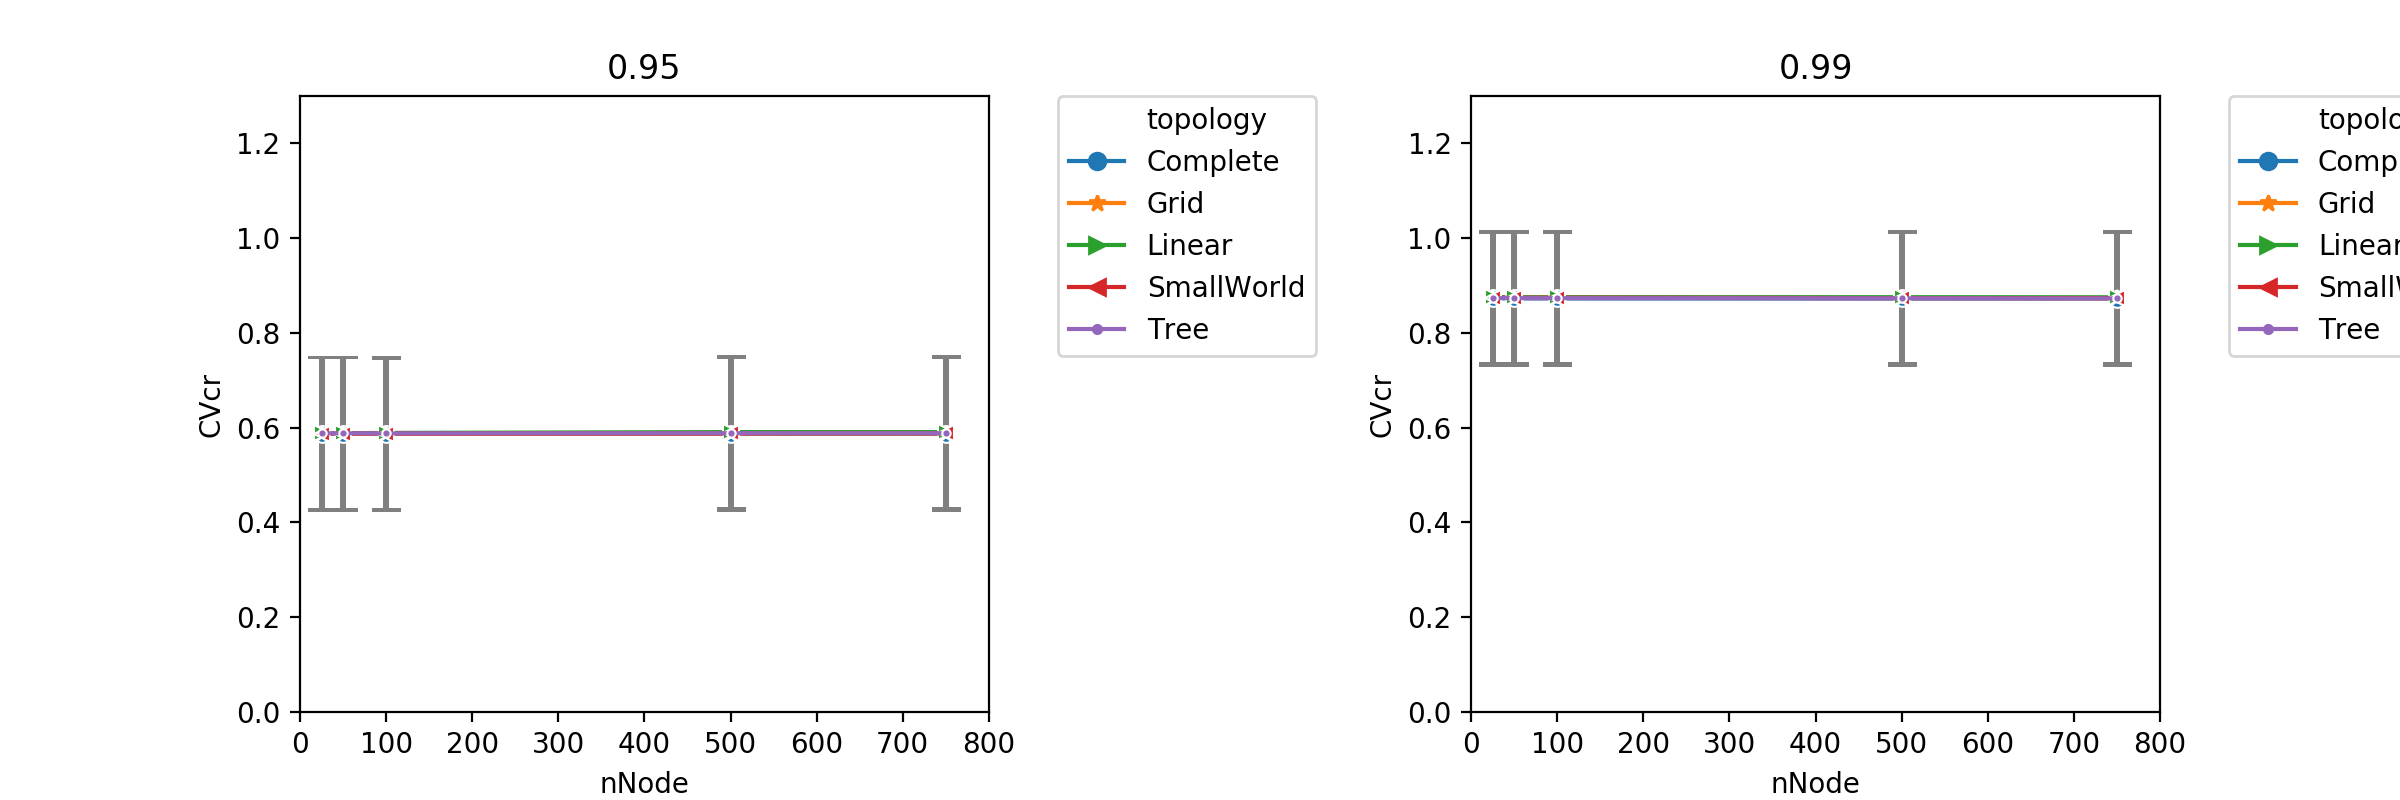

In [12]:
df = dfall_env_sync.loc[(dfall_env_sync.r_std==1.0)&(dfall_env_sync.rho_eta_hetero==0.8)&(dfall_env_sync.d==0.05)].groupby(['NetName','d','rho_eta_fluc','color','topology'],as_index=False).agg(np.mean)
yerrd=dfall_env_sync.loc[(dfall_env_sync.r_std==1.0)&(dfall_env_sync.rho_eta_hetero==0.8)&(dfall_env_sync.d==0.05)]
regPlots(df,"nNode","CVcr","rho_eta_fluc","Neutral",color='grey',yerrd=yerrd,xlim=[0,800],ylim=[0,1.3])
# left: Figure 3(j)

### Figure 3(l)

<IPython.core.display.Javascript object>


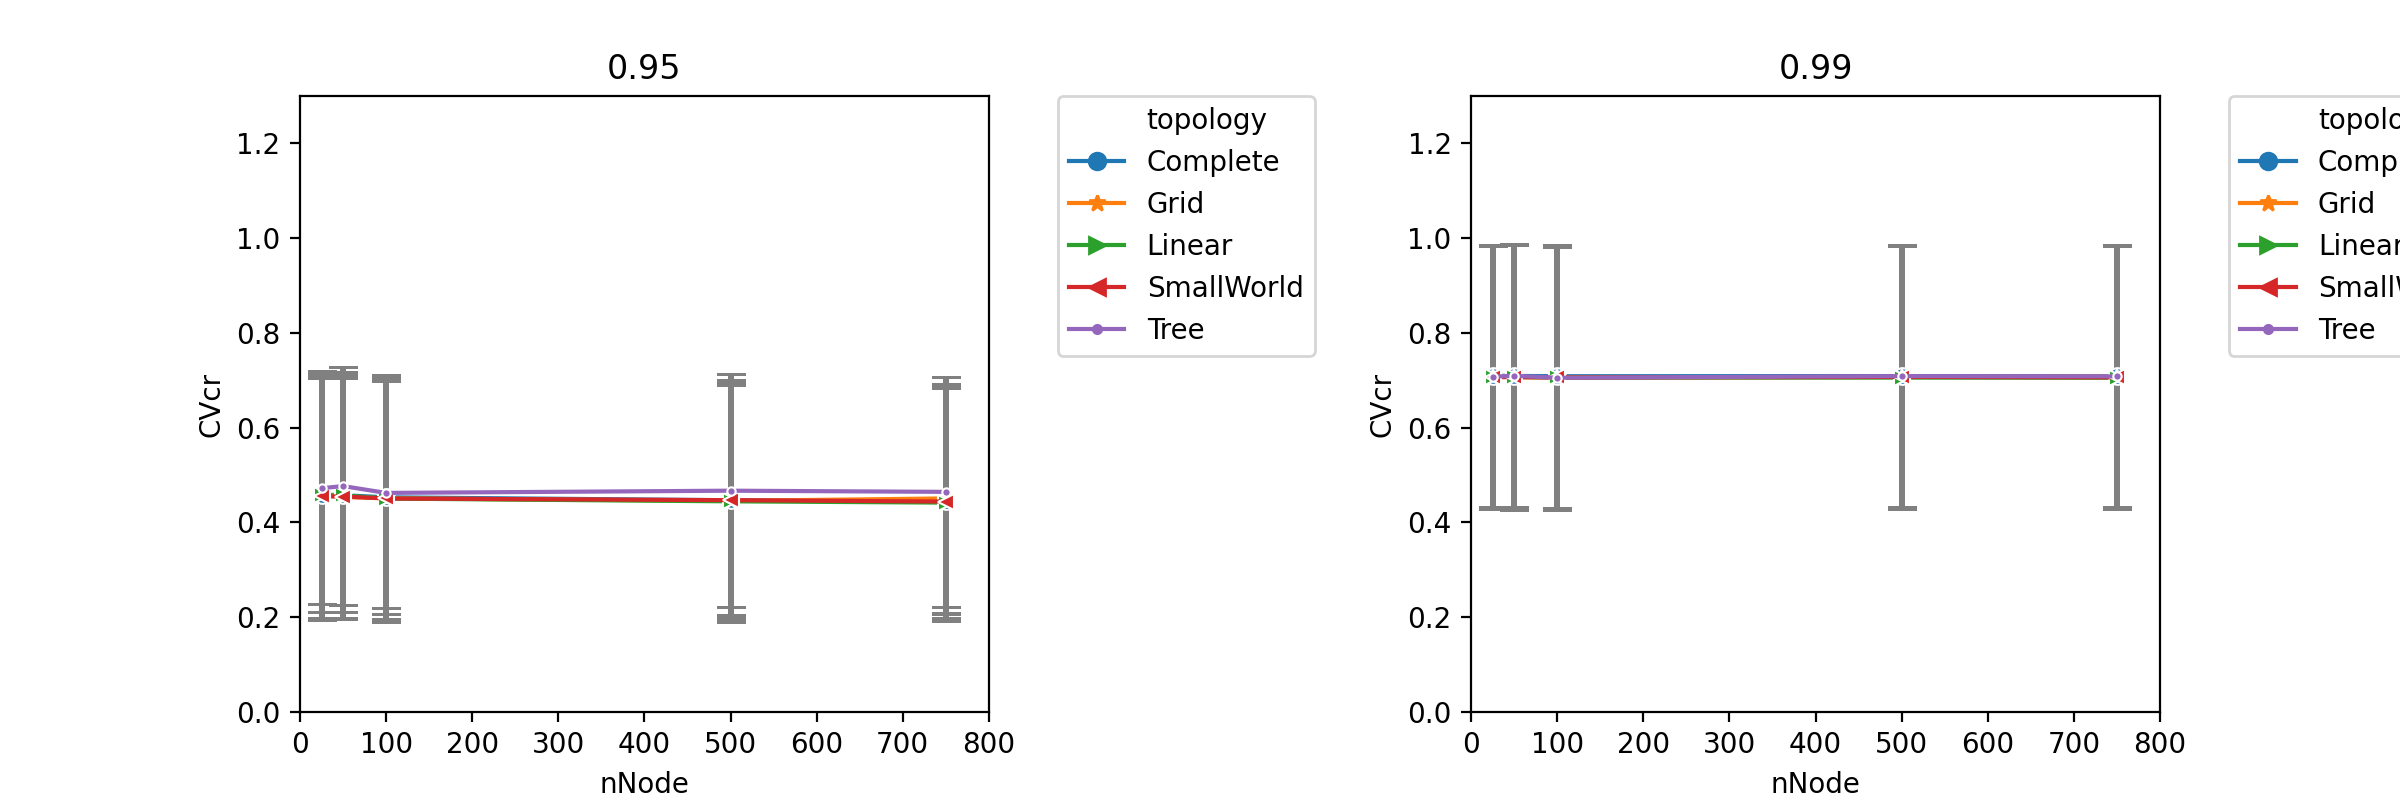

In [27]:
df = dfall_env_sync.loc[(dfall_env_sync.r_std==0.2)&(dfall_env_sync.rho_eta_hetero==0.8)&(dfall_env_sync.d==0.5)].groupby(['NetName','d','rho_eta_fluc','color','topology'],as_index=False).agg(np.mean)
yerrd=dfall_env_sync.loc[(dfall_env_sync.r_std==0.2)&(dfall_env_sync.rho_eta_hetero==0.8)&(dfall_env_sync.d==0.5)]
regPlots(df,"nNode","CVcr","rho_eta_fluc","Neutral",color='grey',yerrd=yerrd,xlim=[0,800],ylim=[0,1.3])
# left: Figure 3(l)

In [8]:
pn25 = np.loadtxt("WL7-4_results_wIm_2021-Mar-18/randc_2021-May-9/sp5_CompleteN25e25_h0.1r0.7asym_rand0_hetero0.8_fluc0.95_std1.0_d0.5")
pn50 = np.loadtxt("WL7-4_results_wIm_2021-Mar-18/randc_2021-May-9/sp5_CompleteN50e50_h0.1r0.7asym_rand0_hetero0.8_fluc0.95_std1.0_d0.5")
pn100 = np.loadtxt("WL7-4_results_wIm_2021-Mar-18/randc_2021-May-9/sp5_CompleteN100e100_h0.1r0.7asym_rand0_hetero0.8_fluc0.95_std1.0_d0.5")
pn500 = np.loadtxt("WL7-4_results_wIm_2021-Mar-18/randc_2021-May-9/sp5_CompleteN500e500_h0.1r0.7asym_rand0_hetero0.8_fluc0.95_std1.0_d0.5")
pn750 = np.loadtxt("WL7-4_results_wIm_2021-Mar-18/randc_2021-May-9/sp5_CompleteN750e750_h0.1r0.7asym_rand0_hetero0.8_fluc0.95_std1.0_d0.5")

<IPython.core.display.Javascript object>


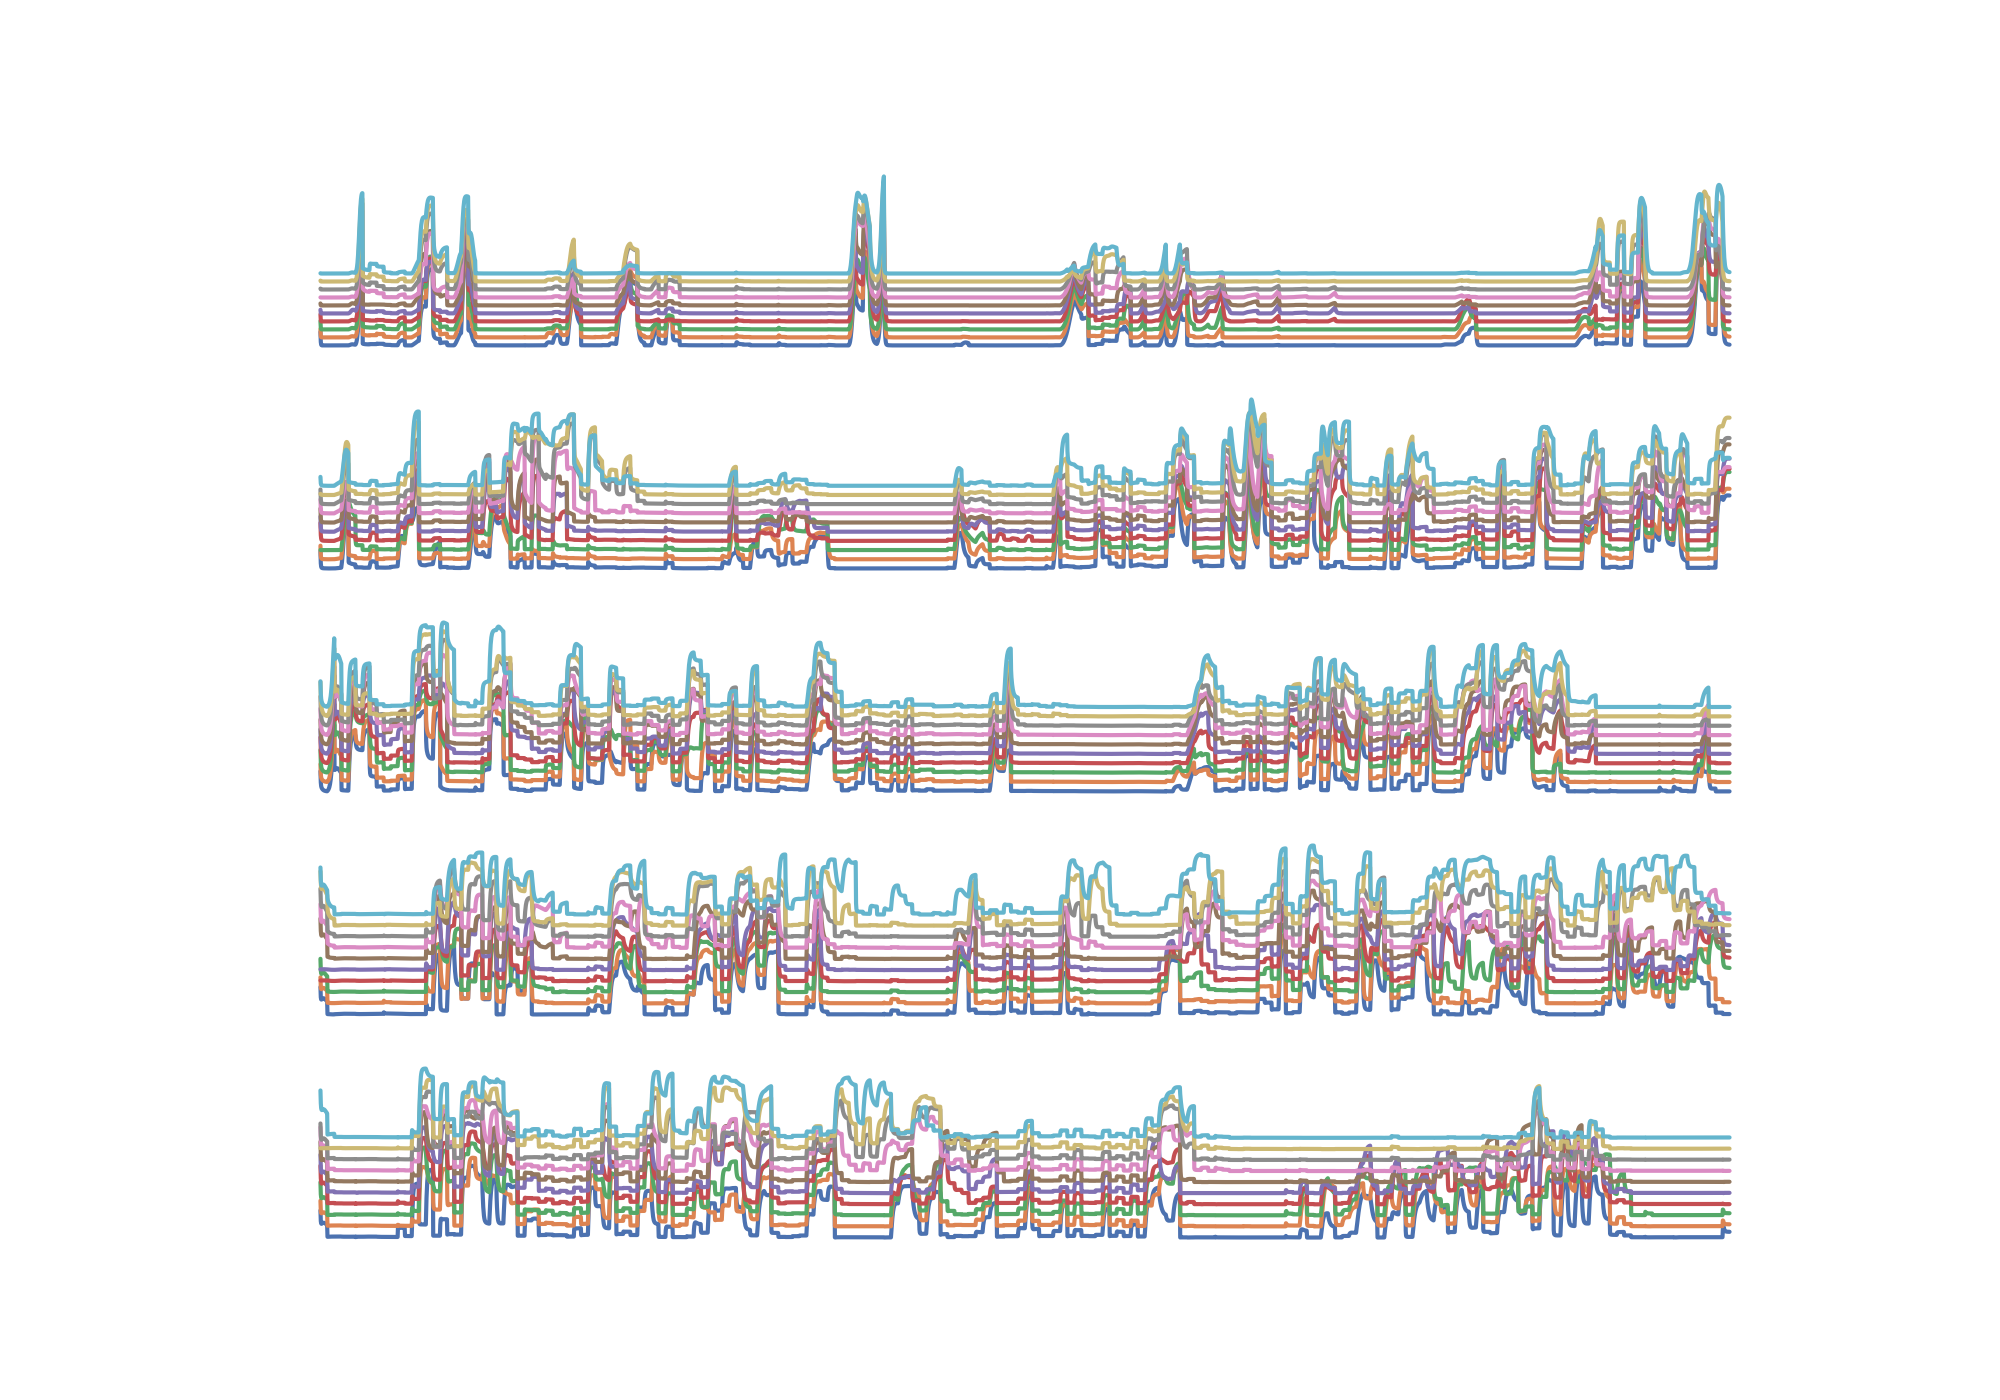

In [28]:
sns.set()
fig, axs = plt.subplots(5,1,figsize=(10,7))
x = range(4000)
height = np.zeros([10,4000]) + np.array([[0],[0.1],[0.2],[0.3],[0.4],[0.5],[0.6],[0.7],[0.8],[0.9]])
_=axs[0].plot((pn25[:10]+height).T)
_=axs[1].plot((pn50[:10]+height).T)
_=axs[2].plot((pn100[:10]+height).T)
_=axs[3].plot((pn500[:10]+height).T)
_=axs[4].plot((pn750[:10]+height).T)
_=axs[0].axis('off')
_=axs[1].axis('off')
_=axs[2].axis('off')
_=axs[3].axis('off')
_=axs[4].axis('off')

### Figure 1

<IPython.core.display.Javascript object>


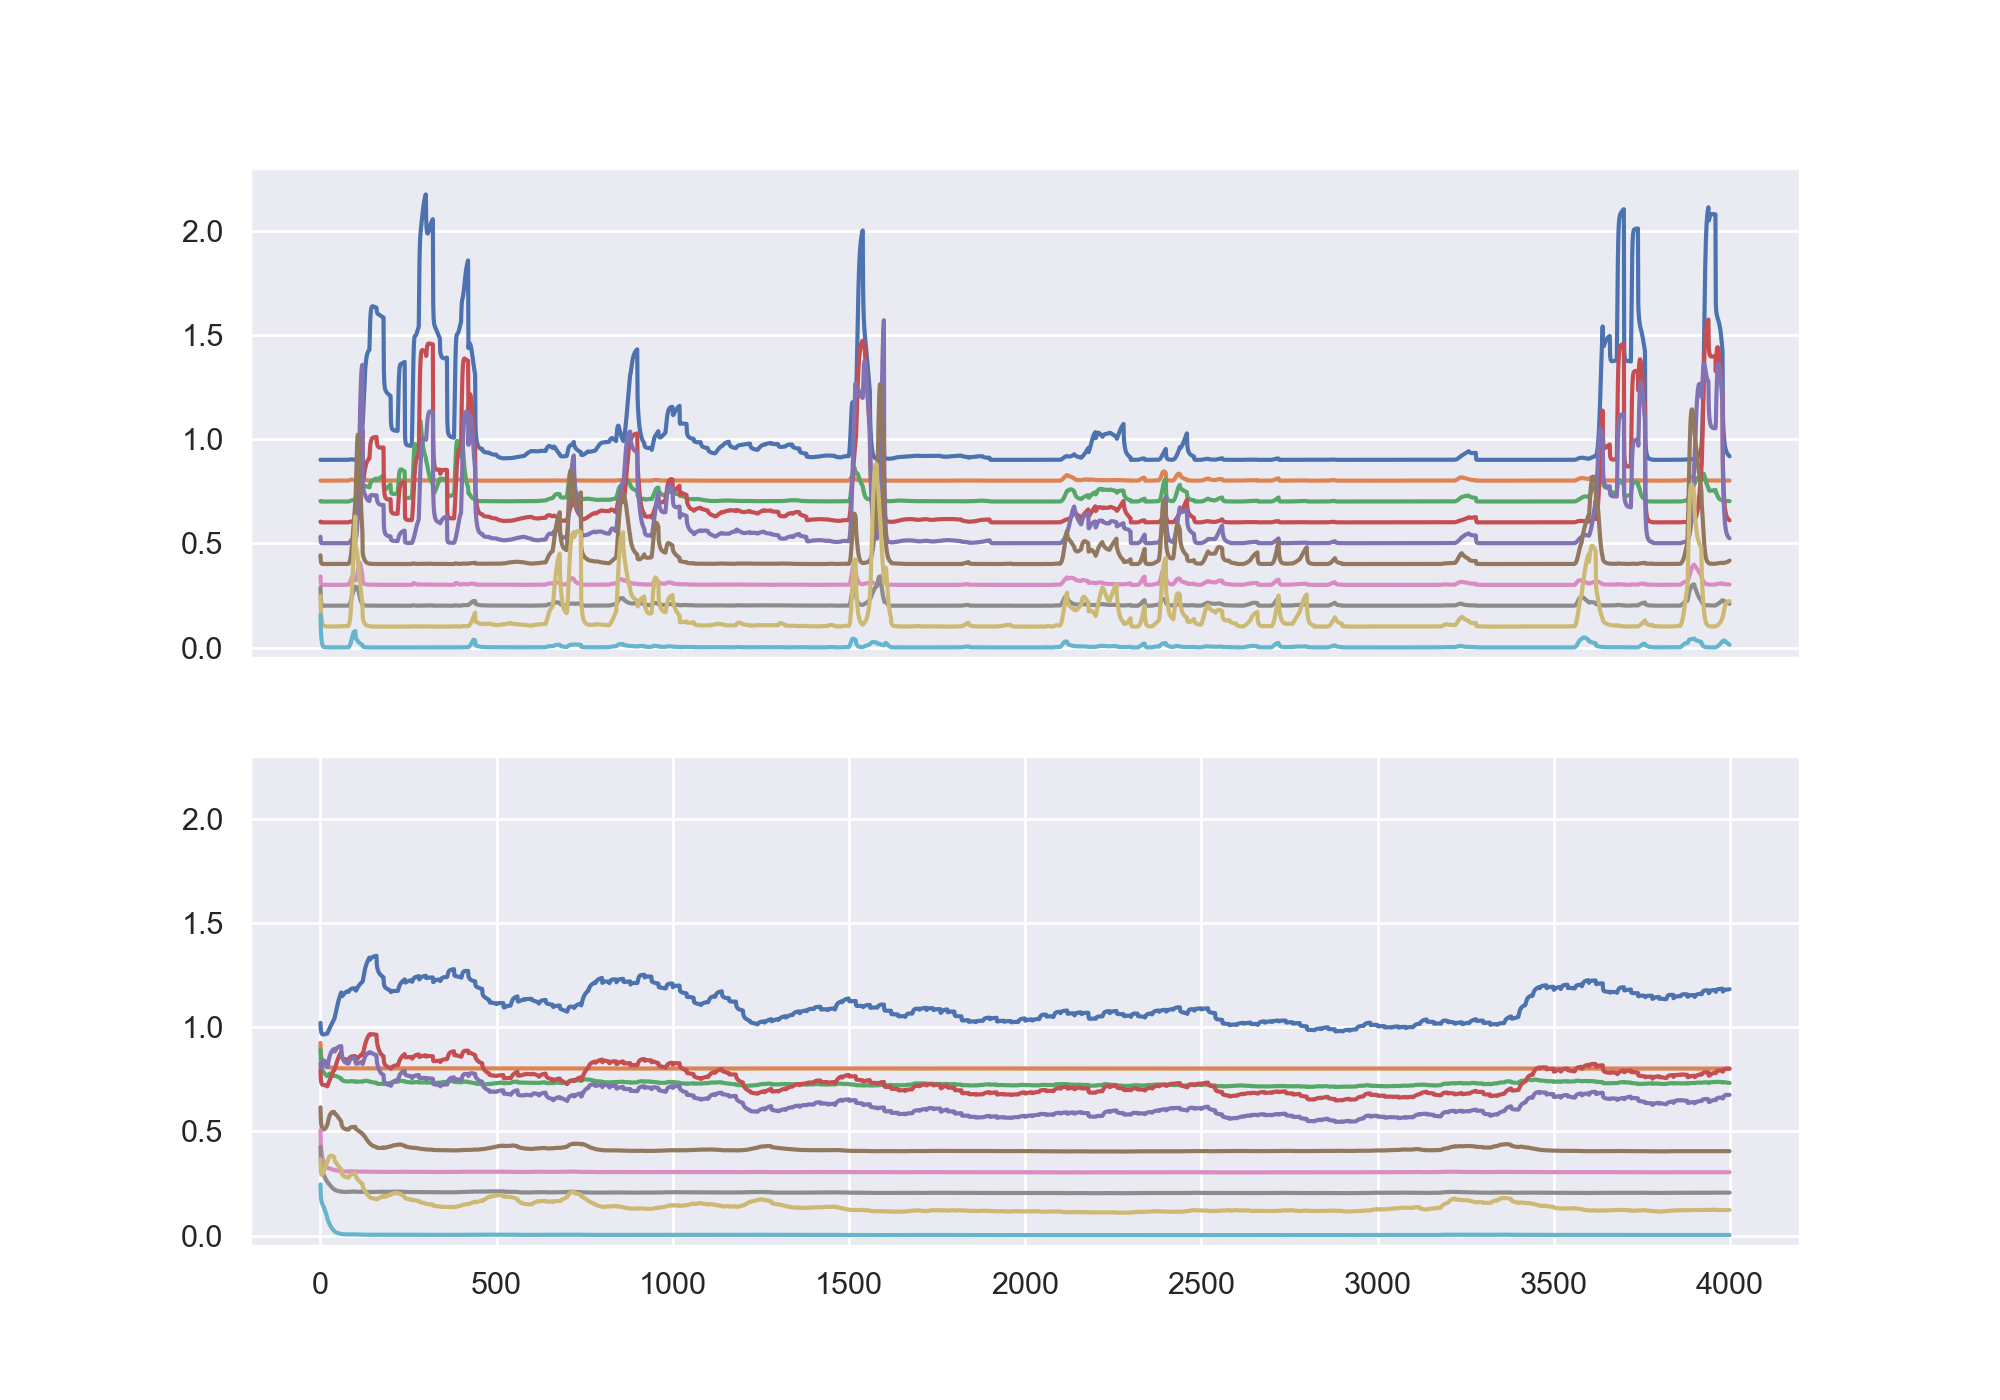

In [4]:
pn25 = np.loadtxt("WL7-4_results_wIm_2021-Mar-18/randc_2021-May-9/metacom-scale_CompleteN25e25_h0.1r0.7asym_rand0_hetero0.8_fluc0.95_std1.0_d0.5") / 25
pn50 = np.loadtxt("WL7-4_results_wIm_2021-Mar-18/randc_2021-May-9/metacom-scale_CompleteN50e50_h0.1r0.7asym_rand0_hetero0.8_fluc0.95_std1.0_d0.5") / 50
pn100 = np.loadtxt("WL7-4_results_wIm_2021-Mar-18/randc_2021-May-9/metacom-scale_CompleteN100e100_h0.1r0.7asym_rand0_hetero0.8_fluc0.95_std1.0_d0.5") / 100
pn500 = np.loadtxt("WL7-4_results_wIm_2021-Mar-18/randc_2021-May-9/metacom-scale_CompleteN500e500_h0.1r0.7asym_rand0_hetero0.8_fluc0.95_std1.0_d0.5") / 500
pn750 = np.loadtxt("WL7-4_results_wIm_2021-Mar-18/randc_2021-May-9/metacom-scale_CompleteN750e750_h0.1r0.7asym_rand0_hetero0.8_fluc0.95_std1.0_d0.5") / 750

sns.set()
fig, axs = plt.subplots(2,1,figsize=(10,7))
x = range(4000)
n_sp = 10
height = np.zeros([n_sp,4000]) + np.array([[0.9],[0.8],[0.7],[0.6],[0.5],[0.4],[0.3],[0.2],[0.1],[0]])
_=axs[0].plot((pn25[:n_sp]+height).T)
_=axs[1].plot((pn750[:n_sp]+height).T)
_=axs[0].set_ylim([-0.05,2.3])
_=axs[1].set_ylim([-0.05,2.3])
_=axs[0].set_xticks([],[])
#_=axs[0].axis('off')
#_=axs[1].axis('off')